In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
anndata2ri.activate()

# Load data

In [4]:
# Load data
data_dir = '/nfs/team205/ig7/projects/fetal_skin/data/'
ver_stamp = 'A1_V1'
x_partition = 'X_scvi'
adata = sc.read_h5ad('{d}/{t}_FS_new_Gene_norm_qc_sliced_scvi.h5ad'.format(d=data_dir, t=ver_stamp)) #from 220523_A1_V1_SK_basic_preprocessing_scvi.ipynb
adata

AnnData object with n_obs × n_vars = 186533 × 10000
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'lr_batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'donor_colors', 'hvg', 'independent_annotation_refined_20220202_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'normalised_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Account for FACS sorting

In [5]:
facs_prop_df = pd.read_csv('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/FS_sort_counts_v2.csv')
facs_prop_df

,orig.ident,Sample.lanes,age,sort.ids,origin,count,total_live_events,parent_Multiplier,remarks,sort_sample_id
0,F16,4834STDY7002879,8,CD45+,skin,12939,385631,0.033553,NaN,skin_F16_385631
1,F16,4834STDY7002880,8,CD45-,skin,371538,385631,0.963455,NaN,skin_F16_385631
2,F17,4834STDY7038752,9,CD45+,skin,11514,517311,0.022257,NaN,skin_F17_586671
3,F17,4834STDY7038753,9,CD45-,skin,505206,517311,0.976600,NaN,skin_F17_586671
4,F19,FCAImmP7241241,10,CD45+,skin,22826,919270,0.024831,NaN,skin_F19_919270
5,F19,FCAImmP7241240,10,CD45-,skin,895669,919270,0.974326,NaN,skin_F19_919270
6,F32,FCAImmP7316896,7,CD45+,skin,317,8903,0.035606,NaN,skin_F32_8903
7,F32,FCAImmP7316897,7,CD45-,skin,8586,8903,0.964394,NaN,skin_F32_8903
8,F33,FCAImmP7316886,9,CD45+,skin,77153,1474021,0.052342,NaN,skin_F33_1474021
9,F33,FCAImmP7316887,9,CD45+,skin,77153,1474021,0.052342,NaN,skin_F33_1474021


In [6]:
facs_prop_df = facs_prop_df[facs_prop_df['origin'].isin(['skin'])]
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]
## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")
facs_prop_df.head(10)

,orig.ident,Sample.lanes,age,sort.ids,origin,count,total_live_events,parent_Multiplier,remarks,sort_sample_id
0,F16,4834STDY7002879,8,CD45+,skin,12939,385631,0.033553,NaN,skin_F16_385631
1,F16,4834STDY7002880,8,CD45-,skin,371538,385631,0.963455,NaN,skin_F16_385631
2,F17,4834STDY7038752,9,CD45+,skin,11514,517311,0.022257,NaN,skin_F17_517311
3,F17,4834STDY7038753,9,CD45-,skin,505206,517311,0.976600,NaN,skin_F17_517311
4,F19,FCAImmP7241241,10,CD45+,skin,22826,919270,0.024831,NaN,skin_F19_919270
5,F19,FCAImmP7241240,10,CD45-,skin,895669,919270,0.974326,NaN,skin_F19_919270
6,F32,FCAImmP7316896,7,CD45+,skin,317,8903,0.035606,NaN,skin_F32_8903
7,F32,FCAImmP7316897,7,CD45-,skin,8586,8903,0.964394,NaN,skin_F32_8903
8,F33,FCAImmP7316886,9,CD45+,skin,77153,1474021,0.052342,NaN,skin_F33_1474021
9,F33,FCAImmP7316887,9,CD45+,skin,77153,1474021,0.052342,NaN,skin_F33_1474021


In [7]:
adata.obs.columns = adata.obs.columns.str.replace('_orig','')
adata.obs['stage'] = adata.obs['pcw']
adata.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,independent_annotation_refined_20220202,age,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,lr_batch,_scvi_batch,_scvi_labels,stage
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,LYVE1++ macrophage,8,1712,2471.715088,43.581497,1.763209,"F16,SC3Pv2",0,0,8
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,Monocyte (activated/differentiating),8,2629,2887.716553,32.130589,1.112664,"F16,SC3Pv2",0,0,8
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,LYVE1++ macrophage,8,2237,2837.357422,26.172831,0.922437,"F16,SC3Pv2",0,0,8
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,Eo/baso/mast cell progenitor,8,2913,2634.364014,27.313688,1.036823,"F16,SC3Pv2",0,0,8
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,LYVE1++ macrophage,8,2217,2773.782471,36.504738,1.316064,"F16,SC3Pv2",0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,Pericytes,14,1920,2690.864990,31.811579,1.182206,"F71,SC5P-R2",0,0,14
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,Pericytes,14,2214,2771.604248,37.477379,1.352191,"F71,SC5P-R2",0,0,14
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,Early erythroid,14,661,769.292114,23.784973,3.091800,"F71,SC5P-R2",0,0,14
TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.052632,...,LE,14,3446,3457.381104,41.586975,1.202846,"F71,SC5P-R2",0,0,14


In [8]:
map_lane_ids = 'sanger_id_orig'
#formatting to retain orig values and prevent overwriting
adata.obs.columns = ["{}{}".format(i,'_orig') for i in adata.obs.columns]
# # Map all facs values
for i in facs_prop_df.columns:
    print(i)
    mapper = dict(zip(facs_prop_df['Sample.lanes'],facs_prop_df[i]))
    adata.obs[i] = adata.obs[map_lane_ids].map(mapper)
mapper = dict(zip(facs_prop_df['Sample.lanes'],facs_prop_df['sort.ids']))
adata.obs['sort.ids_orig'] = adata.obs[map_lane_ids].map(mapper)

orig.ident
Sample.lanes
age
sort.ids
origin
count
total_live_events
parent_Multiplier
remarks
sort_sample_id


In [9]:
adata.obs['sort.ids'].unique()

array(['CD45+', 'CD45-', nan], dtype=object)

In [10]:
adata.obs[~adata.obs['sort.ids'].isin(['CD45+', 'CD45-'])]

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,Sample.lanes,age,sort.ids,origin,count,total_live_events,parent_Multiplier,remarks,sort_sample_id,sort.ids_orig
AAACCTGAGAGGTTAT-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.151515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGAGCTTCGCG-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.097744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGGTTTACTCT-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.031977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCTGTCTTAACCT-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.261538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGGTCAAAGAT-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.129909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCGTGTGACCC-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.140127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGCGCAGCTGTCTA-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Empt,0.091346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGCGCCACCGGAAA-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Both,0.164286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGCGCTCCCAACGG-1-4834STDY7002883,4834STDY7002883,SC3Pv2,F17,male,9,Total,F17_male_9+1PCW,SC3Pv2_Total,Empt,0.029787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
adata.obs.groupby(['sanger_id_orig','donor_orig','sort.ids']).apply(len)

sanger_id_orig   donor_orig  sort.ids
4834STDY7002879  F16         CD45+        530
4834STDY7002880  F16         CD45-        307
4834STDY7038752  F17         CD45+        180
4834STDY7038753  F17         CD45-        794
FCAImmP7241240   F19         CD45-        267
FCAImmP7241241   F19         CD45+       4964
FCAImmP7316886   F33         CD45+       3876
FCAImmP7316887   F33         CD45+       3511
FCAImmP7316888   F33         CD45-       5843
FCAImmP7316896   F32         CD45+       2716
FCAImmP7316897   F32         CD45-       7052
FCAImmP7352189   F34         CD45+       2502
FCAImmP7352190   F34         CD45-       5202
FCAImmP7352191   F34         CD45-       5100
FCAImmP7462240   F35         CD45+       3387
FCAImmP7462241   F35         CD45-       4536
FCAImmP7528290   F38         CD45+       4579
FCAImmP7528291   F38         CD45-       4761
FCAImmP7528296   F38         CD45+       4094
FCAImmP7555848   F41         CD45-       3143
FCAImmP7555858   F41         CD45+       2

In [12]:
adata.obs.loc[adata.obs['sort.ids'].isin(['CD45-']),'parent_Multiplier'].unique()

array([0.9634547 , 0.97660015, 0.97432637, 0.94765814, 0.96439402,
       0.96750309, 0.98584951, 0.97299284, 0.01252891, 0.97334878,
       0.98915558, 0.95446018, 0.95720109, 0.9804692 , 0.97314482])

In [13]:
adata.obs.loc[adata.obs['sort.ids'].isin(['CD45+']),'parent_Multiplier'].unique()

array([0.0335528 , 0.0222574 , 0.02483057, 0.05234186, 0.03560598,
       0.03249692, 0.01415049, 0.02700716, 0.98747109, 0.02665122,
       0.01084442, 0.04553981, 0.04279891, 0.0195308 , 0.02685519])

### Visualize on UMAP

/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


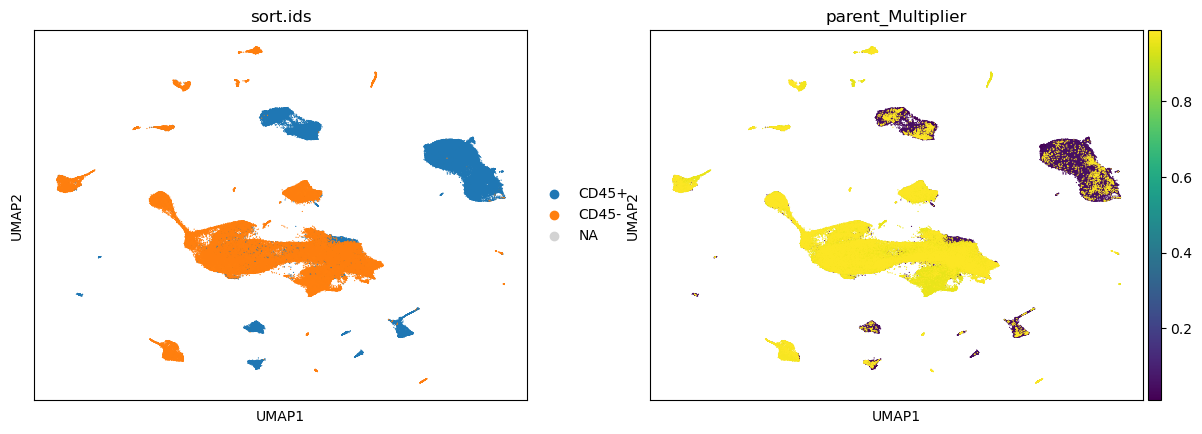

In [14]:
sc.pl.umap(adata, color=["sort.ids","parent_Multiplier"], size=3)

### Is the sorting proportion related to age?

In [15]:
smp_metadata = adata.obs[["sort.ids", "parent_Multiplier", "stage_orig", 'sanger_id_orig', "donor_orig"]].drop_duplicates()

In [16]:
smp_metadata["parent_Multiplier"] = smp_metadata["parent_Multiplier"].astype(float)
smp_metadata["stage_orig"] = smp_metadata["stage_orig"].astype(str)

In [17]:
smp_metadata

,sort.ids,parent_Multiplier,stage_orig,sanger_id_orig,donor_orig
AAACCTGGTCAGTGGA-1-4834STDY7002879,CD45+,0.033553,8,4834STDY7002879,F16
AAAGCAAAGTACGCGA-1-4834STDY7002880,CD45-,0.963455,8,4834STDY7002880,F16
AAACCTGAGAGGTTAT-1-4834STDY7002883,NaN,NaN,9,4834STDY7002883,F17
AAACGGGCAATCGGTT-1-4834STDY7038752,CD45+,0.022257,9,4834STDY7038752,F17
AAACCTGCAGGGCATA-1-4834STDY7038753,CD45-,0.976600,9,4834STDY7038753,F17
AAACGGGGTAGAGGAA-1-FCAImmP7241240,CD45-,0.974326,10,FCAImmP7241240,F19
AAACCTGAGGCGATAC-1-FCAImmP7241241,CD45+,0.024831,10,FCAImmP7241241,F19
AAACCTGAGGGCTCTC-1-FCAImmP7316886,CD45+,0.052342,9,FCAImmP7316886,F33
AAACCTGCAAATACAG-1-FCAImmP7316887,CD45+,0.052342,9,FCAImmP7316887,F33
AAACCTGAGACTTGAA-1-FCAImmP7316888,CD45-,0.947658,9,FCAImmP7316888,F33


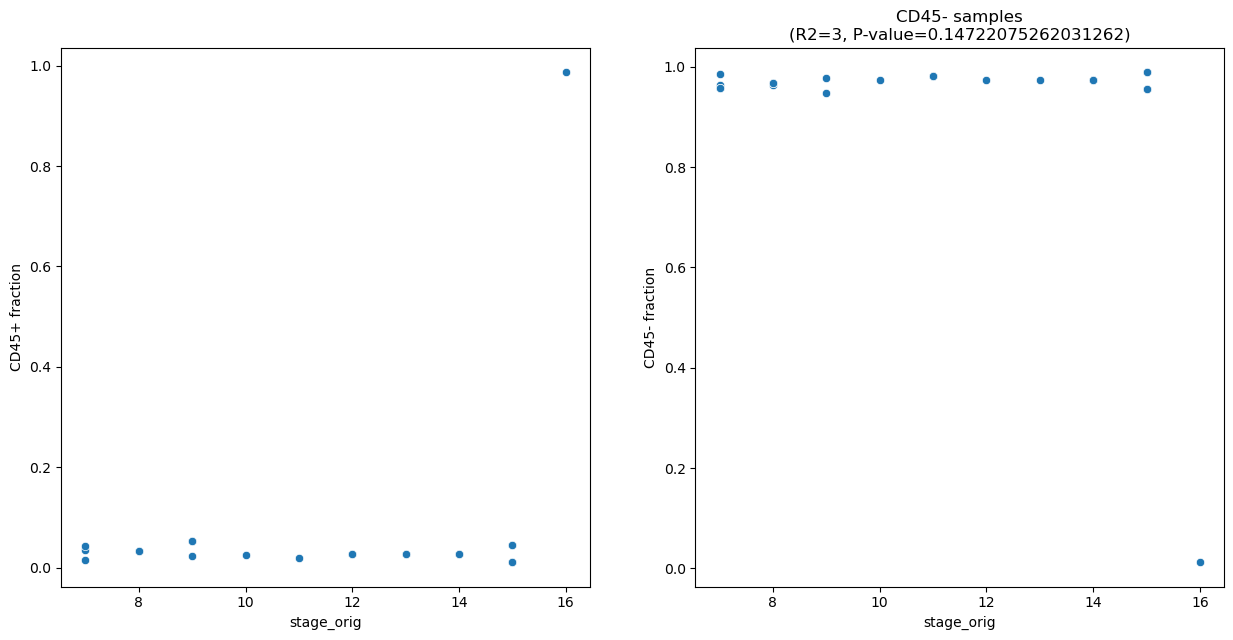

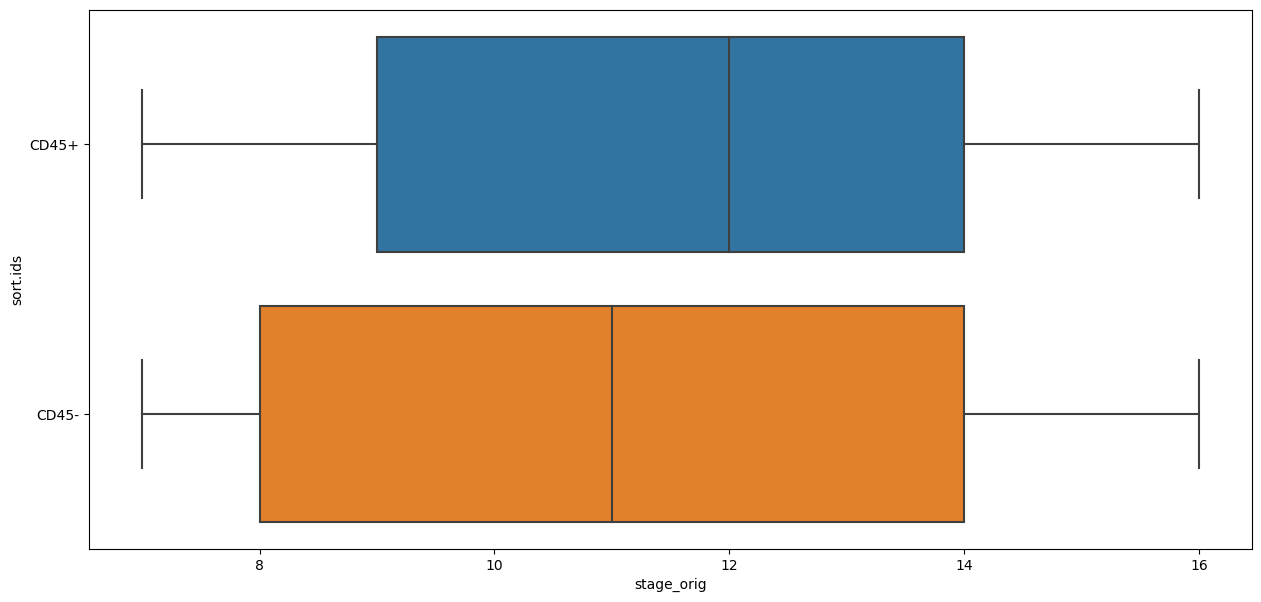

In [18]:
plt.rcParams["figure.figsize"] = [15,7]
plt.subplot(121);
smp_metadata["stage_orig"] = smp_metadata["stage_orig"].astype(str).str.replace('CS','')
smp_metadata["stage_orig"] = smp_metadata["stage_orig"].astype('float')
r2,p_val = scipy.stats.pearsonr(smp_metadata[smp_metadata["sort.ids"]=="CD45+"]["stage_orig"], smp_metadata[smp_metadata["sort.ids"]=="CD45+"]["parent_Multiplier"])
sns.scatterplot(data=smp_metadata[smp_metadata["sort.ids"]=="CD45+"], x="stage_orig", y="parent_Multiplier");
plt.ylabel("CD45+ fraction");
#plt.title("CD45+ samples\n (R2={r}, P-value={p})".format(r=round(r2,3), p=p_val));
plt.subplot(122);
# sns.scatterplot(data=smp_metadata[smp_metadata["sort.ids"]=="CD45-"], x="age", y="parent_Multiplier", hue="sort.ids");
#r2,p_val = scipy.stats.pearsonr(smp_metadata[smp_metadata["sort.ids"]=="CD45-"]["stage_orig"], smp_metadata[smp_metadata["sort.ids"]=="CD45-"]["parent_Multiplier"])
sns.scatterplot(data=smp_metadata[smp_metadata["sort.ids"]=="CD45-"], x="stage_orig", y="parent_Multiplier");
plt.ylabel("CD45- fraction");
plt.title("CD45- samples\n(R2={r}, P-value={p})".format(r=round(3), p=p_val));
plt.show();

sns.boxplot(data=smp_metadata, x="stage_orig", y="sort.ids");
plt.show()

### Pre-processing for differential abundance testing

- chose not to bin the data by stages in this instance

In [19]:
cut_labels_4 = ['< 8', '< 10', '< 13', '< 16']
cut_bins = [0, 8, 10, 13, 16]

adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

# Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes
adata.obs['age_bins']
adata.obs.groupby(['age','donor_orig','age_bins']).apply(len)

age   donor_orig  age_bins
7.0   F32         0            9768
      F35         0            7923
      F61         0           16874
8.0   F16         0             837
      F34         0           12804
9.0   F17         1             974
      F33         1           13230
10.0  F19         1            5231
11.0  F69         2           18465
12.0  F45         2            7211
13.0  F38         2           13434
14.0  F51         3           26147
      F71         3           25949
15.0  F50         3           20509
16.0  F41         3            6071
dtype: int64

We keep cells sorted for CD45+, CD45- or total.

In [20]:
### Fix sort ids
### Exclude cells from unconventional sorts
adata = adata[adata.obs["sort.ids"].isin(["CD45+", "CD45-", "Tot"])]

### Calculate correction factor for each sample

We define the correction factor as 

$$ f_{n} = \log \frac{p_n \cdot \sum_n{S_n}}{S_n} $$

where $p_n$ represents the true proportion of cells from sort $n$ in the tissue samples (column `parent_Multiplier` in FACS table), and $S_n$ represents the total number of cells in sort $n$ (of note, this doesn't coincide with the sum of all $c_{n,i}$ since the same cell can be included in multiple neighbourhoods).

For the unsorted samples we set the correction factor to 0.

In [21]:
adata.obs['sort_sample_id'].unique()

['skin_F16_385631', 'skin_F17_517311', 'skin_F19_919270', 'skin_F33_1474021', 'skin_F32_8903', ..., 'skin_F50_1410218', 'skin_F51_1795901', 'skin_F61_1472', 'skin_F69_1248592', 'skin_F71_1481874']
Length: 15
Categories (15, object): ['skin_F16_385631', 'skin_F17_517311', 'skin_F19_919270', 'skin_F32_8903', ..., 'skin_F51_1795901', 'skin_F61_1472', 'skin_F69_1248592', 'skin_F71_1481874']

In [22]:
adata.obs['parent_Multiplier'].unique()

array([0.0335528 , 0.9634547 , 0.0222574 , 0.97660015, 0.97432637,
       0.02483057, 0.05234186, 0.94765814, 0.03560598, 0.96439402,
       0.03249692, 0.96750309, 0.01415049, 0.98584951, 0.02700716,
       0.97299284, 0.01252891, 0.98747109, 0.02665122, 0.97334878,
       0.01084442, 0.98915558, 0.04553981, 0.95446018, 0.04279891,
       0.95720109, 0.0195308 , 0.9804692 , 0.02685519, 0.97314482])

In [23]:
import milopy
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor_orig', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample.lanes"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)

In [24]:
adata

View of AnnData object with n_obs × n_vars = 185427 × 10000
    obs: 'sanger_id_orig', 'chemistry_orig', 'donor_orig', 'gender_orig', 'pcw_orig', 'sorting_orig', 'sample_orig', 'chemistry_sorting_orig', 'cell_caller_orig', 'scrublet_score_orig', 'cluster_scrublet_score_orig', 'doublet_pval_orig', 'bh_doublet_pval_orig', 'n_counts_orig', 'n_genes_orig', 'percent_mito_orig', 'percent_ribo_orig', 'percent_hb_orig', 'fig1b_annotation_20220202_orig', 'joint_annotation_20220202_orig', 'fig1b_annotation_v2_orig', 'independent_annotation_refined_20220202_orig', 'age_orig', 'n_genes_by_counts_orig', 'total_counts_orig', 'total_counts_mt_orig', 'pct_counts_mt_orig', 'lr_batch_orig', '_scvi_batch_orig', '_scvi_labels_orig', 'stage_orig', 'orig.ident', 'Sample.lanes', 'age', 'sort.ids', 'origin', 'count', 'total_live_events', 'parent_Multiplier', 'remarks', 'sort_sample_id', 'sort.ids_orig', 'age_bins'
    var: 'gene_ids', 'feature_types'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'donor_colors'

In [25]:
## Construct neighbourhoods
adata.obsp['scvi_connectivities'] = adata.obsp['connectivities']
adata.obsp['scvi_distances'] = adata.obsp['distances']
adata.obsm['X_pca'] = adata.obsm['X_scvi']
adata.uns['scvi'] = adata.uns['neighbors']
milo.make_nhoods(adata, neighbors_key='scvi', prop=0.1)
## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="sanger_id_orig")

/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [26]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["sort.ids"]=="Tot","correction_factor"] = 0
adata.obs.loc[adata.obs["correction_factor"].isna(),"correction_factor"] = 0

/tmp/ipykernel_2272/1593593257.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")


In [27]:
adata.obs["correction_factor"].unique()

array([-1.27582164,  0.41941838, -0.91923912,  0.07845524,  1.28077791,
       -1.58226033, -1.02805911,  0.33157566, -0.89260122,  0.12574786,
       -0.77909951,  0.08007648, -1.48015409,  0.23602724, -1.378485  ,
        0.4386168 , -1.61617075,  0.31121355, -1.33265793,  0.35813649,
       -1.57661103,  0.2237423 , -1.02514297,  0.26588189, -0.58695342,
        0.05949521, -0.92178565,  0.06877046, -0.96228411,  0.11092925])

In [28]:
adata.obs

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,parent_Multiplier,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,0.033553,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,0.033553,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,0.033553,NaN,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,0.033553,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,0.033553,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,0.973145,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,0.973145,NaN,skin_F71_1481874,CD45-,3,0,1,1.037427,skin_F71_1481874_CD45-,0.110929
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,0.973145,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929
TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.052632,...,0.973145,NaN,skin_F71_1481874,CD45-,3,0,1,1.320137,skin_F71_1481874_CD45-,0.110929


In [29]:
milopy.utils.add_covariate_to_nhoods_var(adata,["correction_factor","age_bins", "sort.ids"])
nhood_adata =adata.uns["nhood_adata"].copy()
df = nhood_adata.var.copy()
df["correction_factor"] = df["correction_factor"].astype("float")
adata.obs['tissue_orig'] = 'skin'

### Test for differences in age using the correction factor as a confounding covariate

In [30]:
import milopy.core as milo
def _milo_test_by_organ(adata, design="~ sort.ids + age_bins", sample_col="sanger_id_orig", test_organs = None):  
    if test_organs is None:
        ## Keep organs covering at least two time-points
        df = adata.obs[["tissue_orig",sample_col, "age_bins"]].drop_duplicates()
        df = df.groupby(["tissue_orig","age_bins"]).count().reset_index().pivot("tissue_orig",columns="age_bins")
        sampled_organs = df.index[(df > 0).sum(1) > 2]
    else:
        sampled_organs = test_organs

    ## Calculate logFC and SpatialFDR within each organ
    milo_res_dict = {}
    for org in sampled_organs:
        print(org)
        org_samples = adata.obs[adata.obs["tissue_orig"] == org][sample_col].unique()
        milo.DA_nhoods(adata, design=design, subset_samples=org_samples)
        milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

    ## Collapse results
    logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
    for k,v in milo_res_dict.items():
        milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
        milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

    org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
    org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)
    return(milo_res_dict, org_fc, org_fdr)

In [31]:
adata.obs['sanger_id_orig'] = adata.obs['sanger_id_orig'].astype(str)
milo_res, org_fc, org_fdr = _milo_test_by_organ(adata, 
                                                      design="~ correction_factor + age_bins",
                                                      test_organs = None
                                                     )

/tmp/ipykernel_2272/1436908062.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(["tissue_orig","age_bins"]).count().reset_index().pivot("tissue_orig",columns="age_bins")


skin


/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/rpy2/robjects/vectors.py:1010: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2177: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  result, tz_parsed = tslib.array_to_datetime(
/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/tmp/ipykernel_2272/1436908062.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'obj

In [32]:
org_fdr

,SpatialFDR_skin
0,8.351480e-02
1,5.777172e-01
2,7.803030e-02
3,5.767634e-01
4,3.111774e-02
...,...
13668,1.117032e-03
13669,8.772952e-05
13670,9.345316e-08
13671,3.453115e-03


In [33]:
org_fc

,logFC_skin
0,-0.467129
1,0.225872
2,0.545171
3,0.455915
4,-0.499632
...,...
13668,0.909980
13669,0.961300
13670,1.556564
13671,0.939307


In [34]:
milo_res

{'skin':                                index_cell  kth_distance     logFC    logCPM  \
 0      ACCCACTAGGCAGTCA-1-4834STDY7002879      1.052995 -0.467129  8.509011   
 1      ACGCCAGAGCAGGTCA-1-4834STDY7002879      1.332812  0.225872  8.100582   
 2      ACGCCAGCACCACCAG-1-4834STDY7002879      1.420252  0.545171  8.029361   
 3      ATAACGCGTAGAGCTG-1-4834STDY7002879      1.358309  0.455915  7.935354   
 4      ATAGACCTCTGCGTAA-1-4834STDY7002879      1.497726 -0.499632  8.008494   
 ...                                   ...           ...       ...       ...   
 13668   TTTACTGTCTGCAGTA-1-FCAImmP7964510      1.247177  0.909980  7.625171   
 13669   TTTCCTCTCATAAAGG-1-FCAImmP7964510      0.435837  0.961300  7.341166   
 13670   TTTGCGCAGCCTTGAT-1-FCAImmP7964510      1.126816  1.556564  7.540454   
 13671   TTTGTCAGTGCGAAAC-1-FCAImmP7964510      1.037427  0.939307  7.671832   
 13672   TTTGTCATCGCAAGCC-1-FCAImmP7964510      1.320137  1.466573  7.823218   
 
                F        PValu

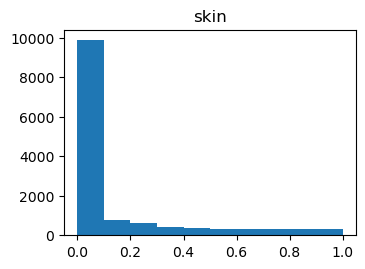

In [35]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res.keys():
    plt.subplot(2,3,i)
    plt.hist(milo_res[k].PValue);
    plt.title(k);
    plt.tight_layout();
    i+=1

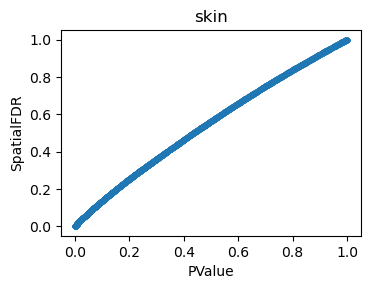

In [36]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res.keys():
    plt.subplot(2,3,i)
    plt.plot(milo_res[k].PValue, milo_res[k].SpatialFDR, '.');
    plt.title(k);
    plt.tight_layout();
    plt.xlabel("PValue");
    plt.ylabel("SpatialFDR");
    i+=1

### Sanity checks

In [37]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,-0.467129,8.509011,3.681059,5.796283e-02,8.471681e-02,8.351480e-02
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,0.225872,8.100582,0.426723,5.151409e-01,5.808132e-01,5.777172e-01
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,0.545171,8.029361,3.813226,5.375057e-02,7.919520e-02,7.803030e-02
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,0.455915,7.935354,2.557827,5.141347e-01,5.798700e-01,5.767634e-01
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,-0.499632,8.008494,5.639032,1.952530e-02,3.178586e-02,3.111774e-02
...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,0.909980,7.625171,12.977361,4.969357e-04,1.173709e-03,1.117032e-03
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,0.961300,7.341166,19.229273,2.934164e-05,9.470923e-05,8.772952e-05
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,1.556564,7.540454,44.229991,5.568452e-09,9.926531e-08,9.345316e-08
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,0.939307,7.671832,10.378170,1.730997e-03,3.588224e-03,3.453115e-03


In [38]:
adata.obs

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,NaN,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,NaN,skin_F71_1481874,CD45-,3,0,1,1.037427,skin_F71_1481874_CD45-,0.110929,skin
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.052632,...,NaN,skin_F71_1481874,CD45-,3,0,1,1.320137,skin_F71_1481874_CD45-,0.110929,skin


### Skip in final run

In [39]:
## Check for neighbourhoods where DA is explained by 10X protocol

milo_res_method, org_fc_method, org_fdr_method = _milo_test_by_organ(adata, 
                                                      design="~ chemistry_orig",
                                                      test_organs = None
                                                )

/tmp/ipykernel_1446/1436908062.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.groupby(["tissue_orig","age_bins"]).count().reset_index().pivot("tissue_orig",columns="age_bins")


skin


/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/tmp/ipykernel_1446/1436908062.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
/tmp/ipykernel_1446/1436908062.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)


In [40]:
org_fc_method

,logFC_skin
0,-0.066913
1,0.088098
2,1.617108
3,0.676151
4,0.203928
...,...
13668,1.694903
13669,2.937991
13670,3.728633
13671,2.156826


In [41]:
org_fdr_method

,SpatialFDR_skin
0,0.964329
1,0.952820
2,0.165757
3,0.556985
4,0.874551
...,...
13668,0.043933
13669,0.000010
13670,0.000002
13671,0.011034


In [77]:
## Exclude neighbourhoods where DA is explained by 10X protocol
org_fc_filtered_2 = org_fc.copy()
org_fdr_filtered_2 = org_fdr.copy()
for o in ["skin"]:
    org_fc_filtered_2["logFC_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan
    org_fdr_filtered_2["SpatialFDR_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan

### Annotate neighbourhoods

In [39]:
## Test for differential abundance between stages
milo.DA_nhoods(adata, design="~ correction_factor + age_bins")

/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [40]:
milopy.utils.annotate_nhoods(adata, anno_col='joint_annotation_20220202_orig')

In [41]:
adata.uns["nhood_adata"].obs["logFC_signif"] = adata.uns["nhood_adata"].obs["logFC"]
#adata.uns["nhood_adata"].obs["logFC_signif"][adata.uns["nhood_adata"].obs["SpatialFDR"] > 0.1] = 0

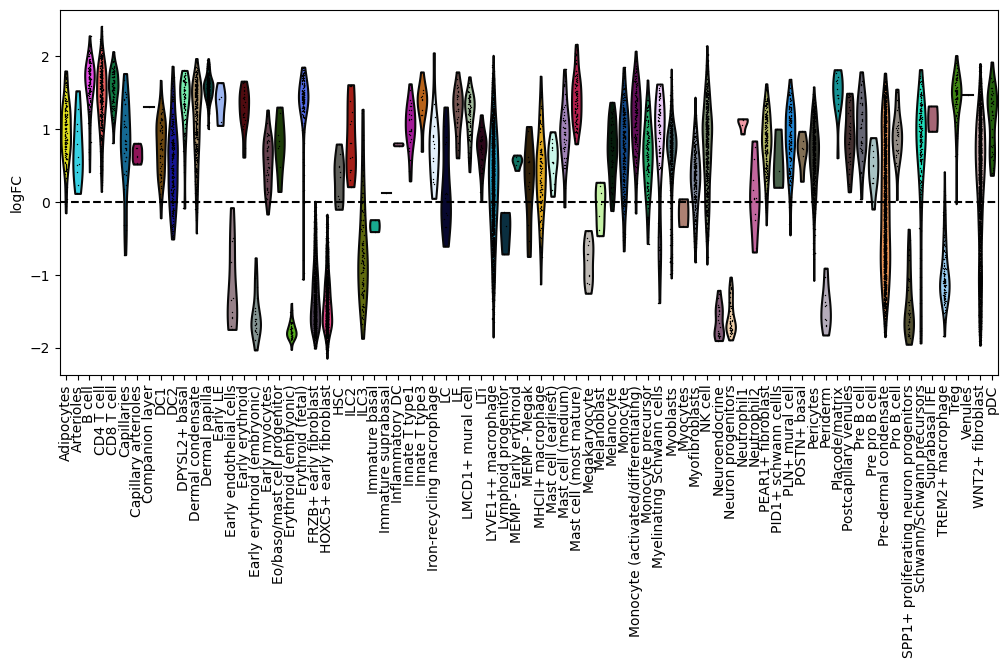

In [42]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# Initial visualisations

In [43]:
#milo_res = adata.uns["nhood_adata"].obs.copy()
#milo_res = milo_res_dict[org]
#milo_res =milo_res[org]
milo_res = adata.uns["nhood_adata"].obs
mapper = dict(zip(adata.obs.index,adata.obs['joint_annotation_20220202_orig']))
milo_res['nhood_anno'] = milo_res['index_cell'].map(mapper)
#milo_res_dict[org] = milo_res
milo_res['organ'] = 'SK'

In [44]:
milo_res

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.467129,8.509011,3.681059,5.796283e-02,8.471681e-02,LYVE1++ macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.225872,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte precursor,0.940000,0.225872,Monocyte precursor,SK
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.545171,8.029361,3.813226,5.375057e-02,7.919520e-02,NK cell,0.833333,0.545171,NK cell,SK
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.455915,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.650000,0.455915,Monocyte,SK
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.499632,8.008494,5.639032,1.952530e-02,3.178586e-02,MHCII+ macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.909980,7.625171,12.977361,4.969357e-04,1.173709e-03,LE,1.000000,0.909980,LE,SK
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.961300,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid (fetal),1.000000,0.961300,Erythroid (fetal),SK
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,1.556564,7.540454,44.229991,5.568452e-09,9.926531e-08,DPYSL2+ basal,0.961538,1.556564,DPYSL2+ basal,SK
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.939307,7.671832,10.378170,1.730997e-03,3.588224e-03,Pericytes,0.988235,0.939307,Pericytes,SK


In [45]:
milo_res.to_csv('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/milo_res_test2.csv')

In [46]:
%load_ext rpy2.ipython

In [48]:
%%R -i milo_res
head(milo_res)

                          index_cell kth_distance SpatialFDR      logFC
0 ACCCACTAGGCAGTCA-1-4834STDY7002879     1.052995 0.08351480 -0.4671290
1 ACGCCAGAGCAGGTCA-1-4834STDY7002879     1.332812 0.57771724  0.2258716
2 ACGCCAGCACCACCAG-1-4834STDY7002879     1.420252 0.07803030  0.5451707
3 ATAACGCGTAGAGCTG-1-4834STDY7002879     1.358309 0.57676342  0.4559150
4 ATAGACCTCTGCGTAA-1-4834STDY7002879     1.497726 0.03111774 -0.4996319
5 ATCGAGTGTAAATGAC-1-4834STDY7002879     1.312127 0.18968432  0.4516136
    logCPM         F     PValue        FDR   nhood_annotation
0 8.509011 3.6810585 0.05796283 0.08471681 LYVE1++ macrophage
1 8.100582 0.4267229 0.51514091 0.58081320 Monocyte precursor
2 8.029361 3.8132256 0.05375057 0.07919520            NK cell
3 7.935354 2.5578272 0.51413471 0.57986999           Monocyte
4 8.008494 5.6390320 0.01952530 0.03178586  MHCII+ macrophage
5 8.501323 2.1689137 0.14401851 0.19154778 LYVE1++ macrophage
  nhood_annotation_frac logFC_signif                          

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
In addition: Warning message:
In system("timedatectl", intern = TRUE) :
  running command 'timedatectl' had status 1


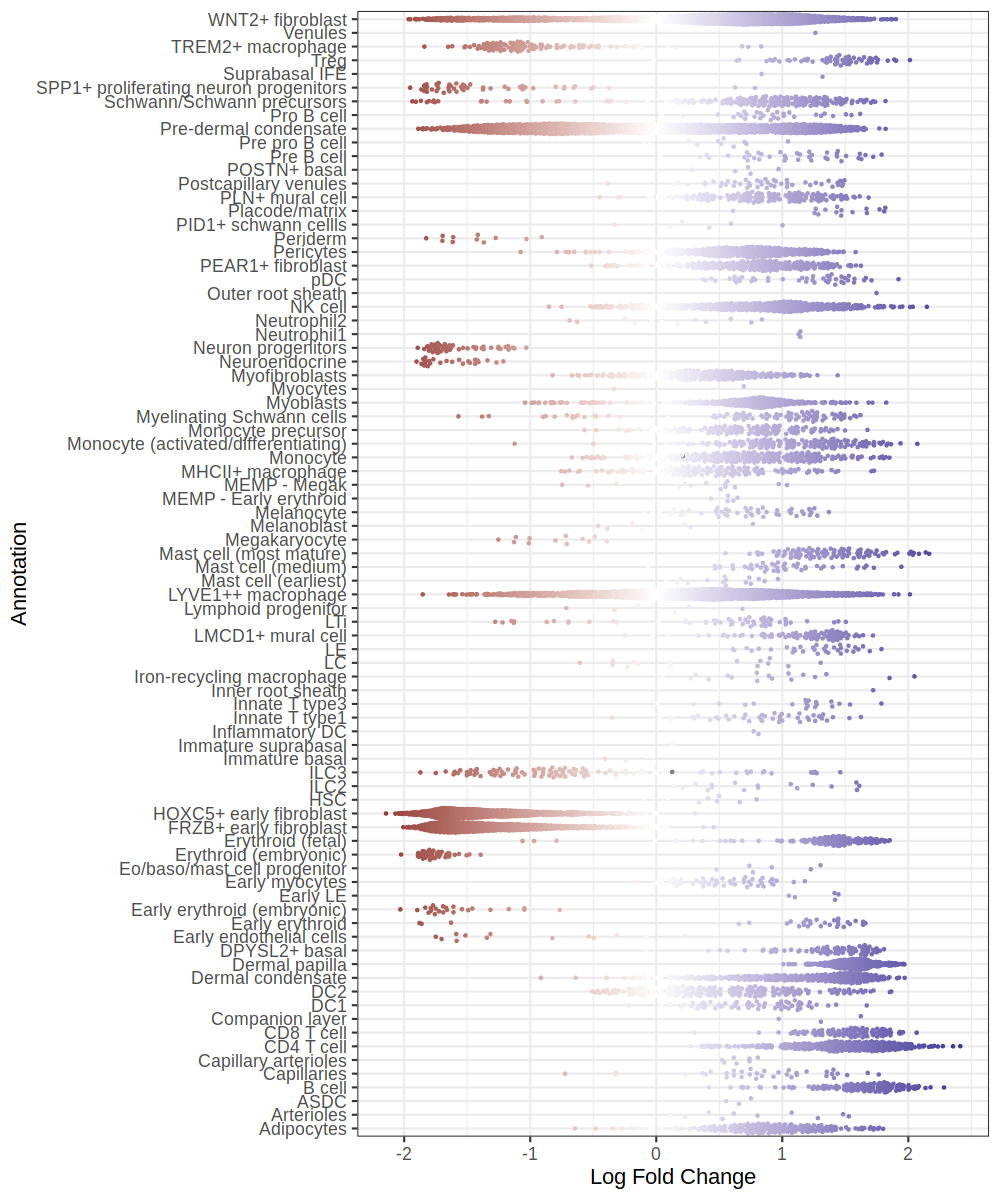

In [49]:
%%R -w 1000 -h 1200
library(tidyverse)
library(ggbeeswarm)

milo_res %>% 
 mutate(is_signif = ifelse(SpatialFDR < 1, 1, 0)) %>%
    mutate(logFC_color = ifelse(is_signif==1, logFC, NA)) %>%
    ggplot(aes(nhood_anno, logFC, color=logFC_color)) +
    scale_color_gradient2() +
    guides(color="none") +
    xlab("Annotation") + ylab("Log Fold Change") +
    geom_quasirandom(alpha=1) +
    coord_flip() +
    theme_bw(base_size=22) +
    theme(strip.text.y =  element_text(angle=0))

/home/jovyan/my-conda-envs/sctk2/lib/python3.9/site-packages/milopy/plot.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df['is_signif'] = anno_df['SpatialFDR'] < alpha


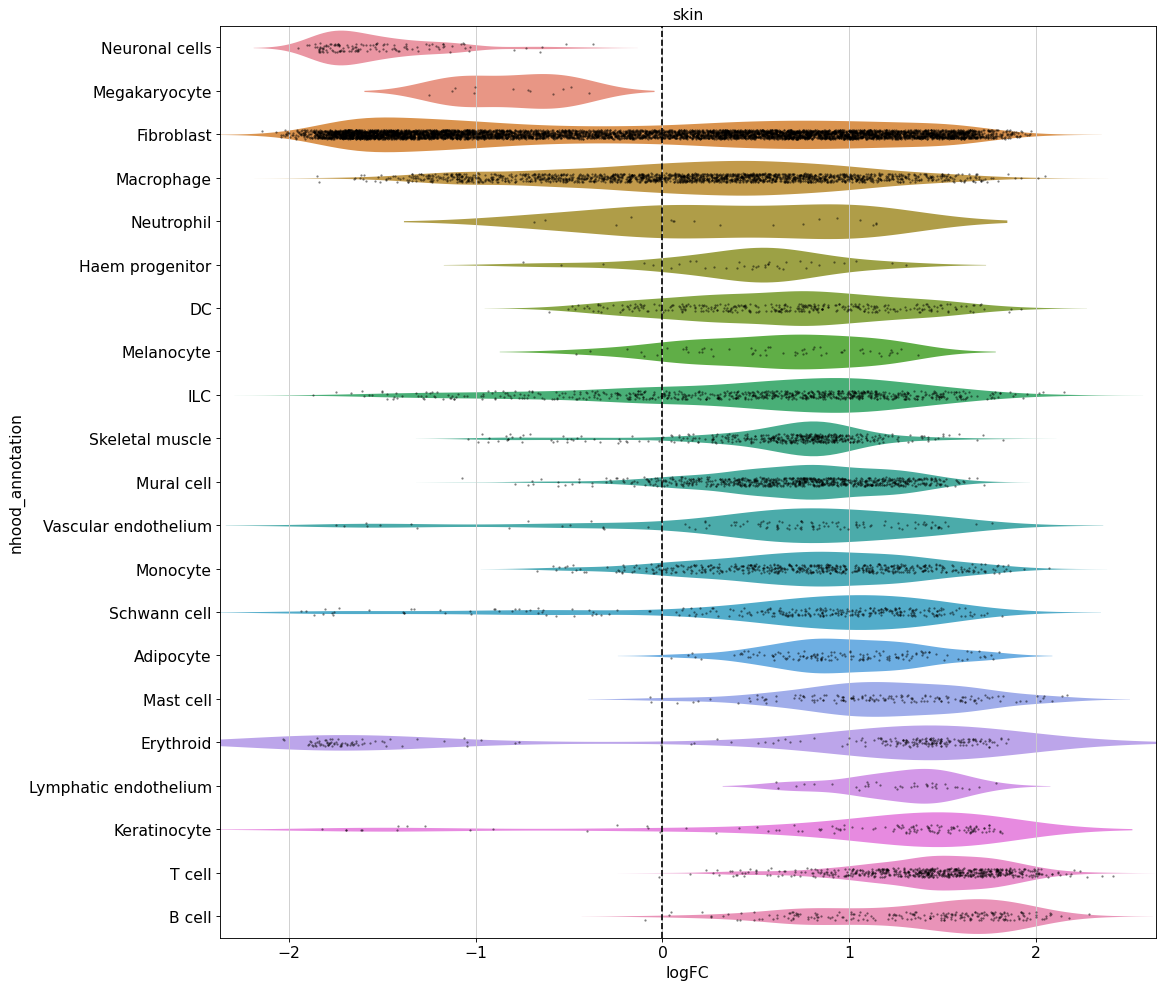

In [50]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=[15,15], color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

milopy.utils.annotate_nhoods(adata, anno_col='fig1b_annotation_v2_orig')
milopl.plot_DA_beeswarm(adata);
plt.title('skin');
plt.show()

# Visualise beeswarm

In [51]:
# Scale the logfc values to -1 and 1
import numpy as np
milo_res['logFC'] = (milo_res['logFC']- np.min(milo_res['logFC']))/(np.max(milo_res['logFC']) - np.min(milo_res['logFC']))
lower, upper = -1, 1
milo_res['logFC'] = [lower + (upper - lower) * x for x in milo_res['logFC']]
milo_res['logFC']

0       -0.263958
1        0.040190
2        0.180326
3        0.141153
4       -0.278223
           ...   
13668    0.340436
13669    0.362960
13670    0.624212
13671    0.353307
13672    0.584717
Name: logFC, Length: 13673, dtype: float64

In [52]:
milo_res['logFC'].min()

-1.0

In [53]:
milo_res['logFC'].max()

1.0

In [54]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.263958,8.509011,3.681059,5.796283e-02,8.471681e-02,Macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.040190,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte,0.960000,0.225872,Monocyte precursor,SK
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.180326,8.029361,3.813226,5.375057e-02,7.919520e-02,ILC,0.833333,0.545171,NK cell,SK
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.141153,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.975000,0.455915,Monocyte,SK
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.278223,8.008494,5.639032,1.952530e-02,3.178586e-02,Macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.340436,7.625171,12.977361,4.969357e-04,1.173709e-03,Lymphatic endothelium,1.000000,0.909980,LE,SK
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.362960,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid,1.000000,0.961300,Erythroid (fetal),SK
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,0.624212,7.540454,44.229991,5.568452e-09,9.926531e-08,Keratinocyte,1.000000,1.556564,DPYSL2+ basal,SK
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.353307,7.671832,10.378170,1.730997e-03,3.588224e-03,Mural cell,0.988235,0.939307,Pericytes,SK


In [55]:
group_map = dict(zip(adata.obs['joint_annotation_20220202_orig'],adata.obs['fig1b_annotation_v2_orig']))
group_map

{'LYVE1++ macrophage': 'Macrophage',
 'Monocyte (activated/differentiating)': 'Monocyte',
 'Eo/baso/mast cell progenitor': 'Haem progenitor',
 'DC2': 'DC',
 'TREM2+ macrophage': 'Macrophage',
 'Monocyte precursor': 'Monocyte',
 'Monocyte': 'Monocyte',
 'WNT2+ fibroblast': 'Fibroblast',
 'Iron-recycling macrophage': 'Macrophage',
 'NK cell': 'ILC',
 'B cell': 'B cell',
 'LTi': 'ILC',
 'ILC3': 'ILC',
 'Inflammatory DC': 'DC',
 'MEMP - Early erythroid': 'Haem progenitor',
 'CD4 T cell': 'T cell',
 'Pro B cell': 'B cell',
 'HSC': 'Haem progenitor',
 'Pre B cell': 'B cell',
 'MHCII+ macrophage': 'Macrophage',
 'LE': 'Lymphatic endothelium',
 'Pre pro B cell': 'B cell',
 'Innate T type1': 'T cell',
 'CD8 T cell': 'T cell',
 'Myocytes': 'Skeletal muscle',
 'pDC': 'DC',
 'Mast cell (most mature)': 'Mast cell',
 'DC1': 'DC',
 'Mast cell (medium)': 'Mast cell',
 'Capillaries': 'Vascular endothelium',
 'Neutrophil2': 'Neutrophil',
 'Capillary arterioles': 'Vascular endothelium',
 'LC': 'DC',
 'Me

In [56]:
milo_res['anno_group'] = milo_res['nhood_anno'].map(group_map)

In [57]:
milo_res

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,anno_group
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.263958,8.509011,3.681059,5.796283e-02,8.471681e-02,Macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK,Macrophage
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.040190,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte,0.960000,0.225872,Monocyte precursor,SK,Monocyte
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.180326,8.029361,3.813226,5.375057e-02,7.919520e-02,ILC,0.833333,0.545171,NK cell,SK,ILC
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.141153,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.975000,0.455915,Monocyte,SK,Monocyte
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.278223,8.008494,5.639032,1.952530e-02,3.178586e-02,Macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK,Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.340436,7.625171,12.977361,4.969357e-04,1.173709e-03,Lymphatic endothelium,1.000000,0.909980,LE,SK,Lymphatic endothelium
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.362960,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid,1.000000,0.961300,Erythroid (fetal),SK,Erythroid
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,0.624212,7.540454,44.229991,5.568452e-09,9.926531e-08,Keratinocyte,1.000000,1.556564,DPYSL2+ basal,SK,Keratinocyte
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.353307,7.671832,10.378170,1.730997e-03,3.588224e-03,Mural cell,0.988235,0.939307,Pericytes,SK,Mural cell


In [58]:
org_fc_filtered = milo_res[['logFC','nhood_anno','anno_group']]
org_fc_filtered.columns = ['logFC_SK','nhood_anno','anno_group']
org_fc_filtered['index_cell'] = milo_res['index_cell']
#org_fc_filtered.loc[org_fc_filtered['index_cell'].isin(adata.uns["nhood_adata"].obs.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5,'index_cell']), "nhood_anno"] = "Mixed"
org_fc_filtered = org_fc_filtered.drop('index_cell',axis=1)

/tmp/ipykernel_2272/1927083346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_fc_filtered['index_cell'] = milo_res['index_cell']


In [59]:
org_fc_filtered

,logFC_SK,nhood_anno,anno_group
0,-0.263958,LYVE1++ macrophage,Macrophage
1,0.040190,Monocyte precursor,Monocyte
2,0.180326,NK cell,ILC
3,0.141153,Monocyte,Monocyte
4,-0.278223,Monocyte (activated/differentiating),Monocyte
...,...,...,...
13668,0.340436,LE,Lymphatic endothelium
13669,0.362960,Erythroid (fetal),Erythroid
13670,0.624212,DPYSL2+ basal,Keratinocyte
13671,0.353307,Pericytes,Mural cell


In [60]:
len(org_fc_filtered['nhood_anno'].unique())

82

In [61]:
pd.set_option('display.max_rows', 150)
org_fc_filtered.groupby(['nhood_anno', 'anno_group']).apply(len)

nhood_anno                              anno_group           
ASDC                                    DC                          3
Adipocytes                              Adipocyte                 188
Arterioles                              Vascular endothelium       10
B cell                                  B cell                    138
CD4 T cell                              T cell                    367
CD8 T cell                              T cell                    102
Capillaries                             Vascular endothelium       36
Capillary arterioles                    Vascular endothelium        7
Companion layer                         Keratinocyte                3
DC1                                     DC                         60
DC2                                     DC                        193
DPYSL2+ basal                           Keratinocyte               79
Dermal condensate                       Fibroblast                334
Dermal papilla              

In [62]:
set(list(adata.obs['joint_annotation_20220202_orig'].unique())) - set(list(org_fc_filtered['nhood_anno'].unique()))

{'Cuticle/cortex'}

In [109]:
# not run
#org_fc_filtered.index = org_fdr.index

In [63]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800 -o plot_df

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

#long_org_fdr$SpatialFDR <- milo_res$SpatialFDR
    
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    #filter(!is.na(logFC)) %>%
    #filter(nhood_anno!="nan") %>%
    #filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    #mutate(organ=factor(organ, levels=c("YS"))) %>%
    ## Fix some names
    #mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    #filter(length(unique(Nhood)) > 5) %>%
    ungroup()
    

plot_df$SpatialFDR <-  milo_res$SpatialFDR

head(plot_df)

Joining, by = c("Nhood", "organ")
# A tibble: 6 x 7
  Nhood nhood_anno anno_group organ logFC SpatialFDR mean_logFC
  <fct> <chr>      <chr>      <chr> <dbl>      <dbl>      <dbl>
1 4521  CD4 T cell T cell     SK    1         0.0835      1    
2 4510  CD4 T cell T cell     SK    0.975     0.578       0.975
3 7452  B cell     B cell     SK    0.943     0.0780      0.943
4 11619 CD4 T cell T cell     SK    0.939     0.577       0.939
5 4603  CD4 T cell T cell     SK    0.922     0.0311      0.922
6 4485  CD4 T cell T cell     SK    0.909     0.190       0.909


# Plotting

In [112]:
#group_map_2 = adata.obs.groupby('fig1b_annotation_v2_orig')['joint_annotation_20220202_orig'].unique().apply(list).to_dict()
group_map_2 = plot_df.groupby('anno_group')['nhood_anno'].unique().apply(list).to_dict()

#original order
group_order_v1 = ['Neuronal cells',
'Schwann cell',
'Fibroblast',
'Skeletal muscle',
'Mural cell',
'Vascular endothelium',
'Erythroid',
'Macrophage',
'ILC',
'Keratinocyte',
'Melanocyte',
'Haem progenitor',
'Megakaryocyte',
'Neutrophil',
'Adipocyte',
'Mast cell',
'DC',
'Monocyte',
'Lymphatic endothelium',
'T cell',
'B cell',]

#new order
group_order =  ['Neuronal cells',
'Megakaryocyte',
'Fibroblast',
'Macrophage',
'Neutrophil',
'Haem progenitor',
'DC',
'Melanocyte',
'ILC',
'Skeletal muscle',
'Mural cell',
'Vascular endothelium',
'Monocyte',
'Schwann cell',
'Adipocyte',
'Mast cell',
'Erythroid',
'Lymphatic endothelium',
'Keratinocyte',
'T cell',
'B cell',]

group_map_2 = dict([(key, group_map_2[key]) for key in group_order if key in group_map_2])
cell_order = [item for sublist in[*group_map_2.values()]for item in sublist]

In [113]:
group_map_2

{'Neuronal cells': ['SPP1+ proliferating neuron progenitors',
  'Neuron progenitors',
  'Neuroendocrine'],
 'Megakaryocyte': ['Megakaryocyte'],
 'Fibroblast': ['Dermal condensate',
  'Dermal papilla',
  'WNT2+ fibroblast',
  'Pre-dermal condensate',
  'PEAR1+ fibroblast',
  'Myofibroblasts',
  'FRZB+ early fibroblast',
  'HOXC5+ early fibroblast'],
 'Macrophage': ['Iron-recycling macrophage',
  'LYVE1++ macrophage',
  'MHCII+ macrophage',
  'TREM2+ macrophage'],
 'Neutrophil': ['Neutrophil1', 'Neutrophil2'],
 'Haem progenitor': ['Eo/baso/mast cell progenitor',
  'MEMP - Megak',
  'HSC',
  'MEMP - Early erythroid'],
 'DC': ['pDC', 'DC2', 'DC1', 'LC', 'Inflammatory DC', 'ASDC'],
 'Melanocyte': ['Melanocyte', 'Melanoblast'],
 'ILC': ['NK cell', 'ILC2', 'LTi', 'ILC3', 'Lymphoid progenitor'],
 'Skeletal muscle': ['Myoblasts', 'Early myocytes', 'Myocytes'],
 'Mural cell': ['LMCD1+ mural cell', 'PLN+ mural cell', 'Pericytes'],
 'Vascular endothelium': ['Capillaries',
  'Arterioles',
  'Postca

In [67]:
figdir = "/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/"

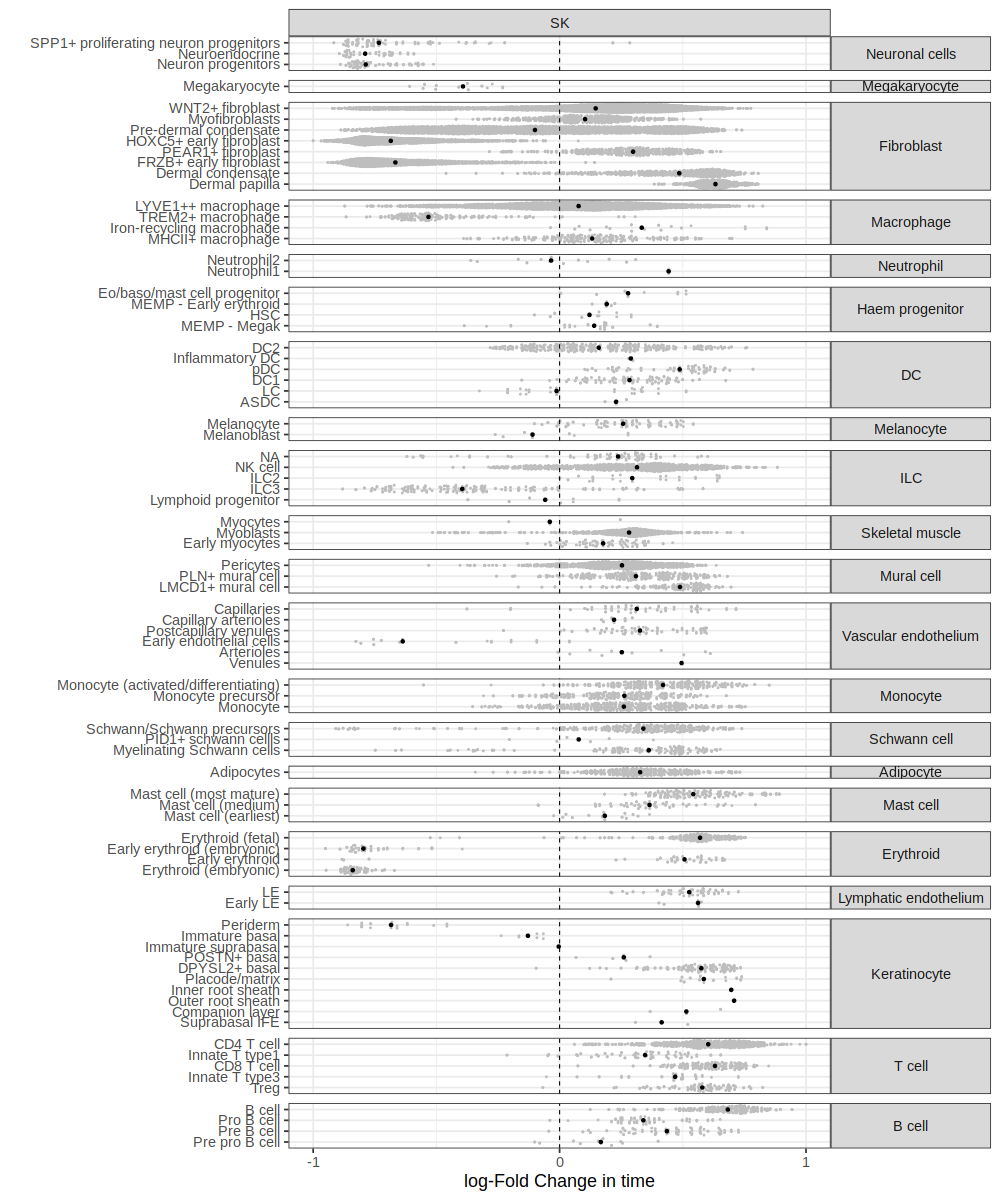

In [68]:
%%R -w 1000 -h 1200 -i figdir -o pl_df
library(ggbeeswarm)
#organ_colors_df <- read.csv("./organ_colors.csv")
#organ = 'SK'
#organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)
organ_palette <- setNames(c('grey'), c('SK'))

anno_group_order <- c(
'Neuronal cells',
'Megakaryocyte',
'Fibroblast',
'Macrophage',
'Neutrophil',
'Haem progenitor',
'DC',
'Melanocyte',
'ILC',
'Skeletal muscle',
'Mural cell',
'Vascular endothelium',
'Monocyte',
'Schwann cell',
'Adipocyte',
'Mast cell',
'Erythroid',
'Lymphatic endothelium',
'Keratinocyte',
'T cell',
'B cell')

anno_order <- c(
'SPP1+ proliferating neuron progenitors',
 'Neuroendocrine',
 'Neuron progenitors',
 'Schwann/Schwann precursors',
 'PID1+ schwann cellls',
 'Myelinating Schwann cells',
 'WNT2+ fibroblast',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'FRZB+ early fibroblast',
 'Dermal condensate',
 'Dermal papilla',
 'Myocytes',
 'Myoblasts',
 'Early myocytes',
 'Pericytes',
 'PLN+ mural cell',
 'LMCD1+ mural cell',
 'Capillaries',
 'Capillary arterioles',
 'Postcapillary venules',
 'Early endothelial cells',
 'Arterioles',
 'Venules',
 'Erythroid (fetal)',
 'Early erythroid (embryonic)',
 'Early erythroid',
 'Erythroid (embryonic)',
 'LYVE1++ macrophage',
 'TREM2+ macrophage',
 'Iron-recycling macrophage',
 'MHCII+ macrophage',
 'NK cell',
 'LTi ce',
 'ILC2',
 'ILC3',
 'Lymphoid progenitor',
 'Periderm',
 'Immature basal',
 'Immature suprabasal',
 'POSTN+ basal',
 'DPYSL2+ basal',
 'Placode/matrix',
 'Inner root sheath',
 'Cuticle/cortex',
 'Outer root sheath',
 'Companion layer',
 'Suprabasal IFE',
 'Melanocyte',
 'Melanoblast',
 'Eo/baso/mast cell progenitor',
 'MEMP - Early erythroid',
 'HSC',
 'MEMP - Megak',
 'Megakaryocyte',
 'Neutrophil2',
 'Neutrophil1',
 'Mast cell (most mature)',
 'Mast cell (medium)',
 'Mast cell (earliest)',
 'DC2',
 'Inflammatory DC',
 'pDC',
 'DC1',
 'LC',
 'ASDC',
 'Monocyte (activated/differentiating)',
 'Monocyte precursor',
 'Monocyte',
 'LE',
 'Early LE',
 'CD4 T cell',
 'Innate T type1',
 'CD8 T cell',
 'Innate T type3',
 'Treg',
 'B cell',
 'Pro B cell',
 'Pre B cell',
 'Pre pro B cell',
 'Adipocytes')


pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    #mutate(anno_group=factor(nhood_anno, levels=anno_order)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group))# %>%
    #filter(anno_group %in% c("PROGENITORS", "MYELOID"))
    
pl_df$nhood_anno = factor(pl_df$nhood_anno ,levels =rev(anno_order))

alpha=0.5
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.7, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))  
pl1 
# ggsave(paste0( "./milo_results_overview_beeswarm.pdf"),plot = last_plot(), width=15, height=15)
# pl2
# ggsave(paste0( "./milo_results_overview_broad_beeswarm.pdf"),plot = last_plot(), width=15, height=15)

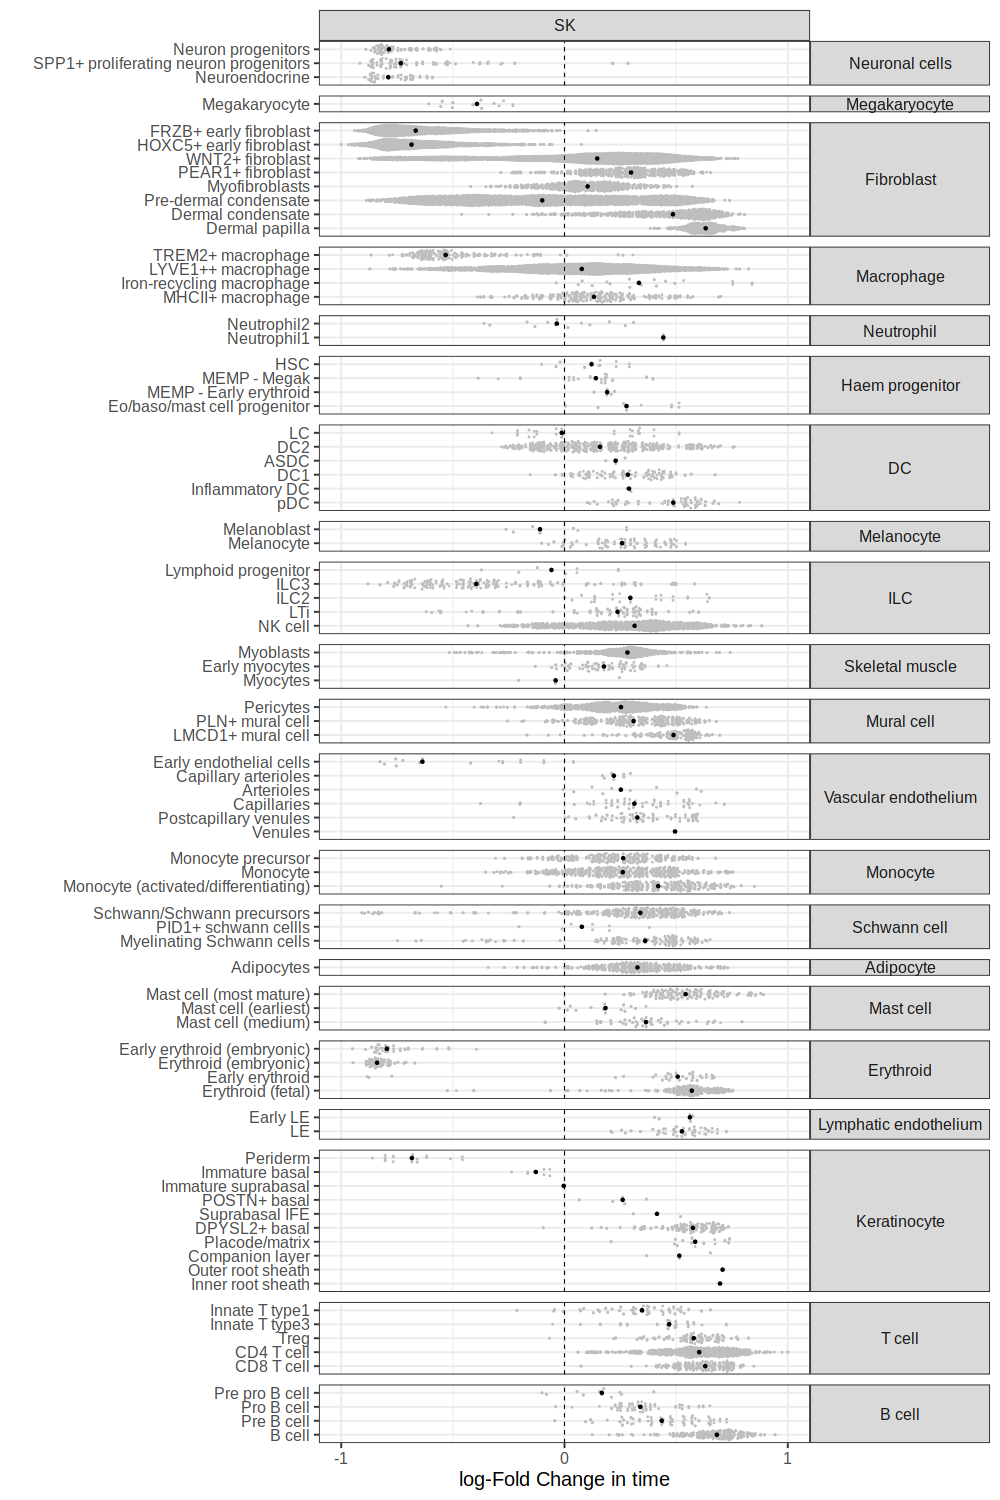

In [69]:
%%R -w 1000 -h 1500 -i figdir -o pl_df
library(ggbeeswarm)
#organ_colors_df <- read.csv("./organ_colors.csv")
#organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)
organ_palette <- setNames(c('grey'), c('SK'))

anno_group_order <- c(
'Neuronal cells',
'Megakaryocyte',
'Fibroblast',
'Macrophage',
'Neutrophil',
'Haem progenitor',
'DC',
'Melanocyte',
'ILC',
'Skeletal muscle',
'Mural cell',
'Vascular endothelium',
'Monocyte',
'Schwann cell',
'Adipocyte',
'Mast cell',
'Erythroid',
'Lymphatic endothelium',
'Keratinocyte',
'T cell',
'B cell')

#cells re-ordered
anno_order <- c(
 'Neuron progenitors',
 'SPP1+ proliferating neuron progenitors',
 'Neuroendocrine',

 'Schwann/Schwann precursors',
 'PID1+ schwann cellls',
 'Myelinating Schwann cells',
    
 'FRZB+ early fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'Dermal condensate',
 'Dermal papilla',
    
 'Myoblasts',
 'Early myocytes',
 'Myocytes',
    
 'Pericytes',
 'PLN+ mural cell',
 'LMCD1+ mural cell',
    
 'Early endothelial cells',
 'Capillary arterioles',
 'Arterioles',
 'Capillaries',
 'Postcapillary venules',
 'Venules',
    
 'Early erythroid (embryonic)',
 'Erythroid (embryonic)',
 'Early erythroid',
 'Erythroid (fetal)',

 'TREM2+ macrophage',
 'LYVE1++ macrophage',
 'Iron-recycling macrophage',
 'MHCII+ macrophage',
    
 'Lymphoid progenitor',
 'ILC3',
 'ILC2',
 'LTi',
 'NK cell',

 'Periderm',
 'Immature basal',
 'Immature suprabasal',
 'POSTN+ basal',
 'Suprabasal IFE',
 'DPYSL2+ basal',
 'Placode/matrix',
 'Companion layer',
 'Outer root sheath',
 'Inner root sheath',
 'Cuticle/cortex',
    
 'Melanoblast',
'Melanocyte',
 
 'HSC',
 'MEMP - Megak',
 'MEMP - Early erythroid',
 'Eo/baso/mast cell progenitor',

 'Megakaryocyte',
    
 'Neutrophil2',
 'Neutrophil1',
    
 'Mast cell (most mature)',
 'Mast cell (earliest)',
 'Mast cell (medium)',
    
 'LC',
 'DC2',
 'ASDC',
 'DC1',
 'Inflammatory DC',
 'pDC',
    
 'Monocyte precursor',
 'Monocyte', 
 'Monocyte (activated/differentiating)',

 'Early LE',
 'LE',
    
 'Innate T type1',
 'Innate T type3',
 'Treg',
 'CD4 T cell',
 'CD8 T cell',

 'Pre pro B cell', 
 'Pro B cell',
 'Pre B cell',
 'B cell',

 'Adipocytes')

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    #mutate(anno_group=factor(nhood_anno, levels=anno_order)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) #%>%
    #filter(!is.na(anno_group))# %>%
    #filter(anno_group %in% c("PROGENITORS", "MYELOID"))
    
pl_df$nhood_anno = factor(pl_df$nhood_anno ,levels =rev(anno_order))

alpha=0.4
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC, color=logFC_color)) +
    geom_quasirandom(size=0.7, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=20) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-4,4, by=1)) +
    theme(strip.text.y=element_text(angle=0))  
pl1 
#ggsave(paste0( figdir, "milo_results_overview_beeswarm_cellabels_v3.pdf"),plot = last_plot(), width=15, height=15)
#pl1
#ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)organ_palette

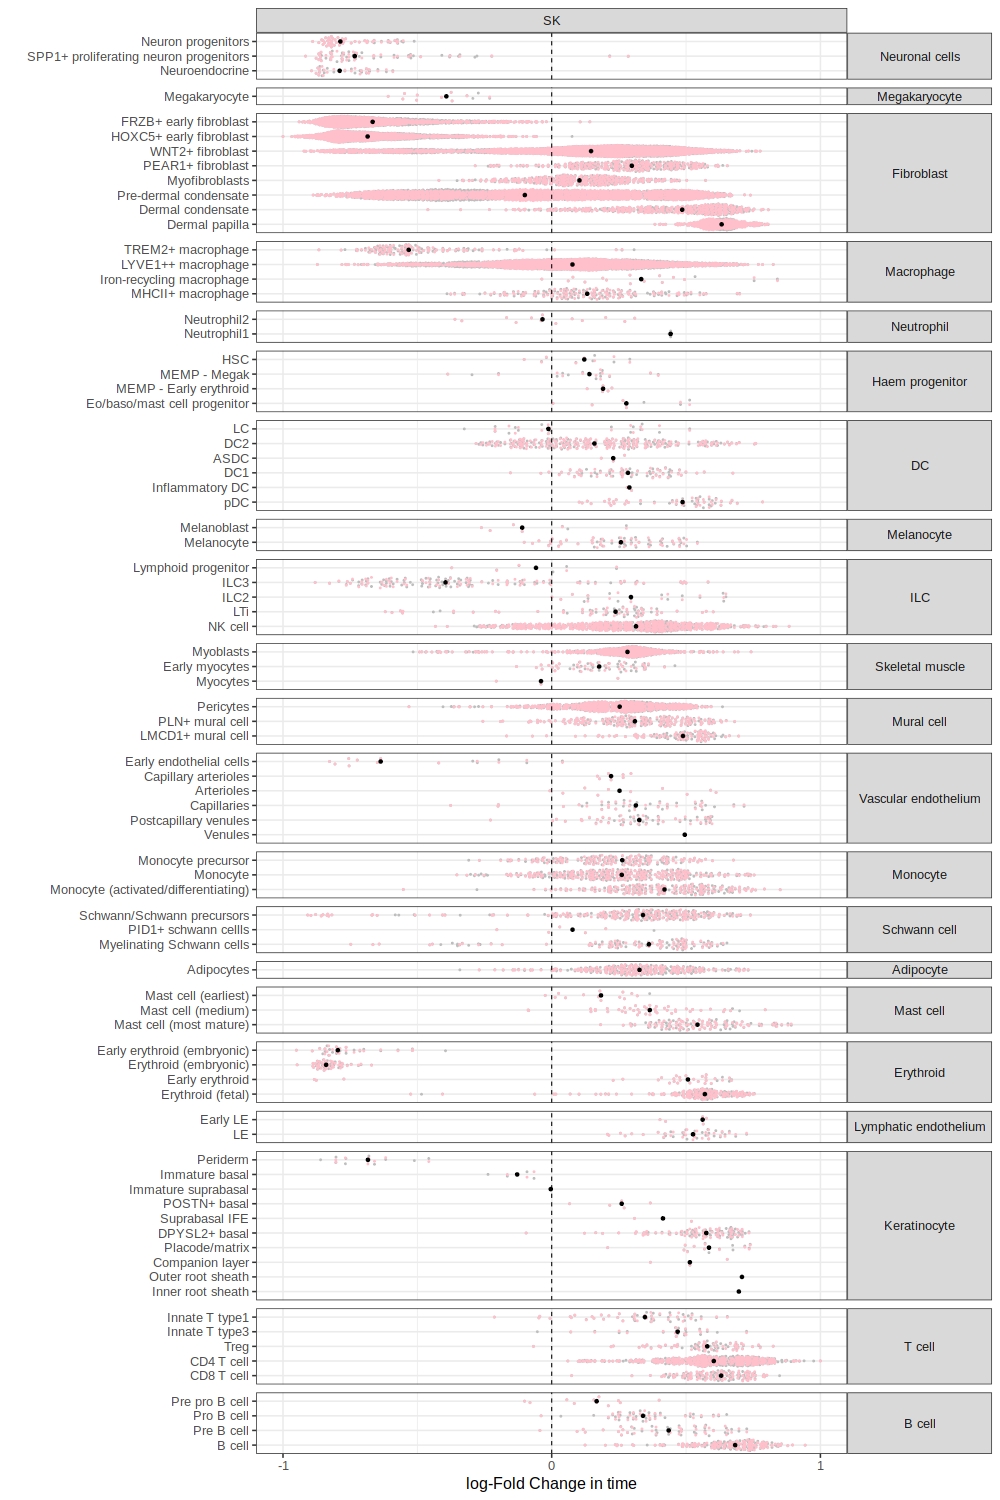

In [72]:
%%R -w 1000 -h 1500 -i figdir -o pl_df
library(ggbeeswarm)
#organ_colors_df <- read.csv("./organ_colors.csv")
#organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)
organ_palette <- setNames(c('pink'), c('SK'))

anno_group_order <- c(
'Neuronal cells',
'Megakaryocyte',
'Fibroblast',
'Macrophage',
'Neutrophil',
'Haem progenitor',
'DC',
'Melanocyte',
'ILC',
'Skeletal muscle',
'Mural cell',
'Vascular endothelium',
'Monocyte',
'Schwann cell',
'Adipocyte',
'Mast cell',
'Erythroid',
'Lymphatic endothelium',
'Keratinocyte',
'T cell',
'B cell')

#cells ordered
anno_order <- c(
 'Neuron progenitors',
 'SPP1+ proliferating neuron progenitors',
 'Neuroendocrine',

 'Schwann/Schwann precursors',
 'PID1+ schwann cellls',
 'Myelinating Schwann cells',
    
 'FRZB+ early fibroblast',
 'HOXC5+ early fibroblast',
 'WNT2+ fibroblast',
 'PEAR1+ fibroblast',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'Dermal condensate',
 'Dermal papilla',
    
 'Myoblasts',
 'Early myocytes',
 'Myocytes',
    
 'Pericytes',
 'PLN+ mural cell',
 'LMCD1+ mural cell',
    
 'Early endothelial cells',
 'Capillary arterioles',
 'Arterioles',
 'Capillaries',
 'Postcapillary venules',
 'Venules',
    
 'Early erythroid (embryonic)',
 'Erythroid (embryonic)',
 'Early erythroid',
 'Erythroid (fetal)',

 'TREM2+ macrophage',
 'LYVE1++ macrophage',
 'Iron-recycling macrophage',
 'MHCII+ macrophage',
    
 'Lymphoid progenitor',
 'ILC3',
 'ILC2',
 'LTi',
 'NK cell',

 'Periderm',
 'Immature basal',
 'Immature suprabasal',
 'POSTN+ basal',
 'Suprabasal IFE',
 'DPYSL2+ basal',
 'Placode/matrix',
 'Companion layer',
 'Outer root sheath',
 'Inner root sheath',
 'Cuticle/cortex',
    
 'Melanoblast',
'Melanocyte',
 
 'HSC',
 'MEMP - Megak',
 'MEMP - Early erythroid',
 'Eo/baso/mast cell progenitor',

 'Megakaryocyte',
    
 'Neutrophil2',
 'Neutrophil1',
    

 'Mast cell (earliest)',
 'Mast cell (medium)',
 'Mast cell (most mature)',
    
 'LC',
 'DC2',
 'ASDC',
 'DC1',
 'Inflammatory DC',
 'pDC',
    
 'Monocyte precursor',
 'Monocyte', 
 'Monocyte (activated/differentiating)',

 'Early LE',
 'LE',
    
 'Innate T type1',
 'Innate T type3',
 'Treg',
 'CD4 T cell',
 'CD8 T cell',

 'Pre pro B cell', 
 'Pro B cell',
 'Pre B cell',
 'B cell',

 'Adipocytes')

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    #mutate(anno_group=factor(nhood_anno, levels=anno_order)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) #%>%
    #filter(!is.na(anno_group))# %>%
    #filter(anno_group %in% c("PROGENITORS", "MYELOID"))
    
pl_df$nhood_anno = factor(pl_df$nhood_anno ,levels =rev(anno_order))

#alpha adjusted
alpha=0.5
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC, color=logFC_color)) +
    geom_quasirandom(size=0.7, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=16) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-4,4, by=1)) +
    theme(strip.text.y=element_text(angle=0))  
#pl1 
#ggsave(paste0( figdir, "milo_results_overview_beeswarm_cellabels_v4.pdf"),plot = last_plot(), width=15, height=15)
pl1
#ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)organ_palette

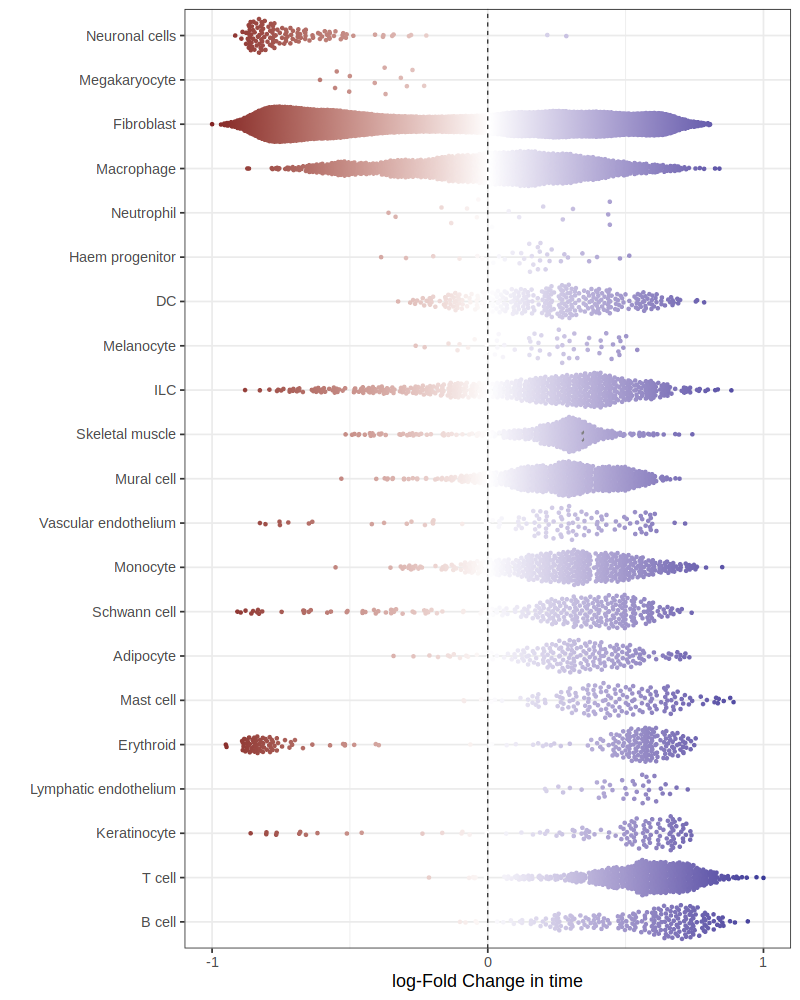

In [75]:
%%R -w 800 -h 1000

plot_df_copy <- plot_df

plot_df_copy$anno_group = factor(plot_df_copy$anno_group ,levels =rev(anno_group_order))
plot_df_copy$nhood_anno = factor(plot_df_copy$nhood_anno ,levels =(anno_order))
plot_df_copy$organ = 'SK'

pl3 <- plot_df_copy %>% 
    mutate(is_signif = ifelse(SpatialFDR < 1, 1, 0)) %>%
    mutate(logFC_color = ifelse(is_signif==1, logFC, NA)) %>%
    ggplot(aes(anno_group, logFC, color=logFC_color)) +
    scale_color_gradient2() +
    geom_quasirandom(alpha=1) +
#   facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))  
ggsave(paste0( figdir, "milo_SK_broad_labels_no_groups_v2.pdf"), plot = last_plot(), width=15, height=15)
pl3

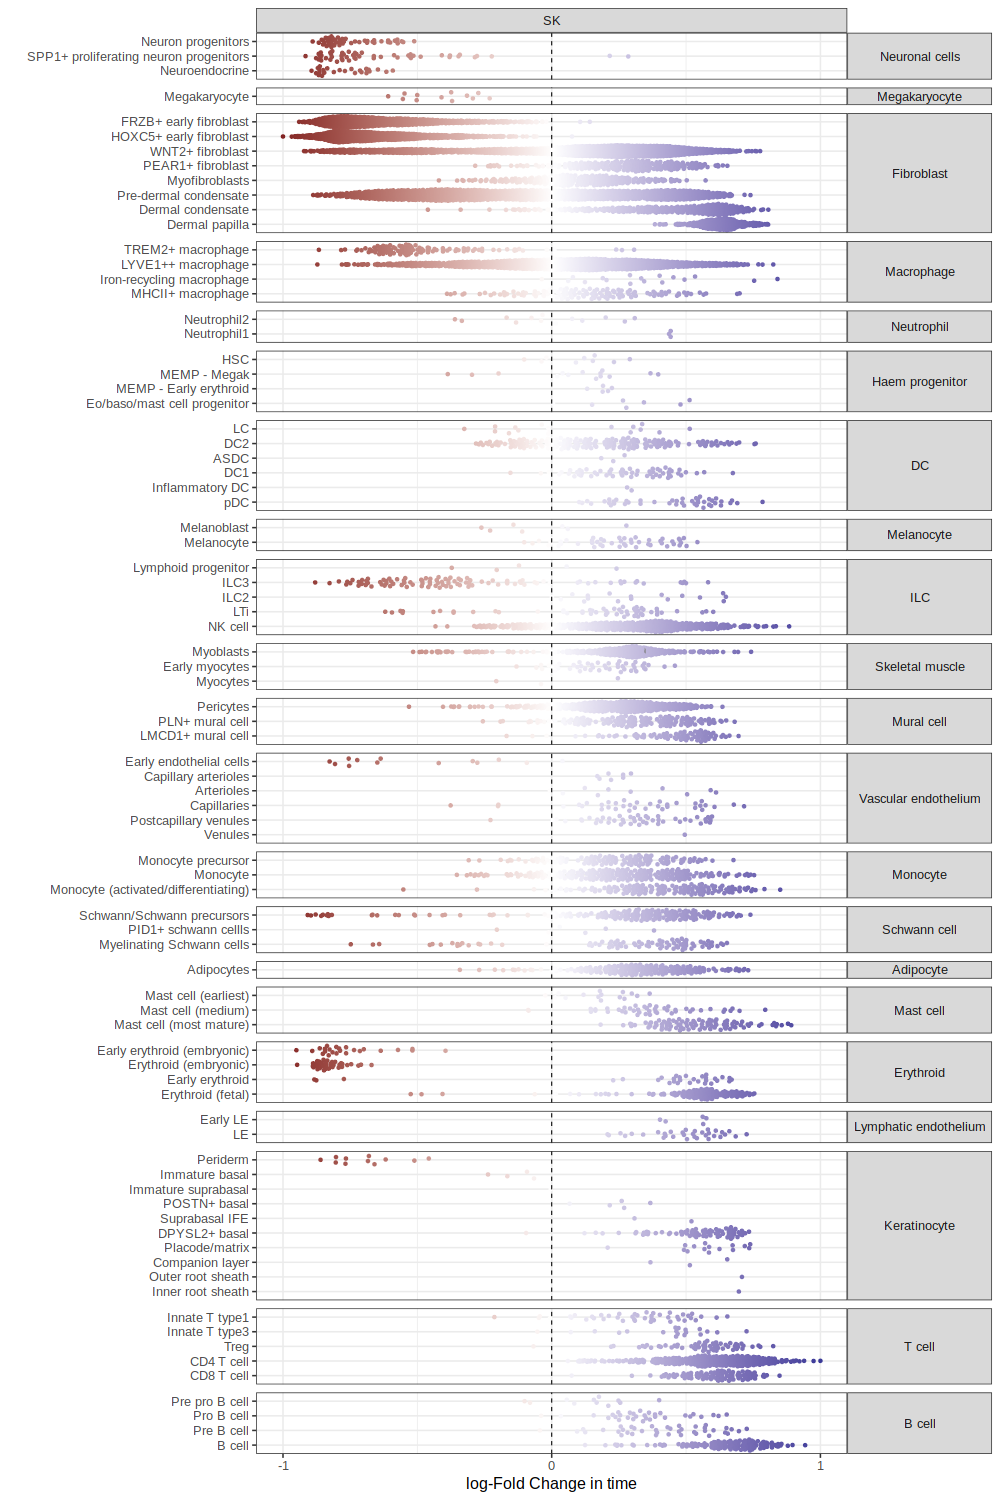

In [76]:
%%R -w 1000 -h 1500

plot_df_copy <- plot_df

plot_df_copy$anno_group = factor(plot_df_copy$anno_group,levels =(anno_group_order))
plot_df_copy$nhood_anno = factor(plot_df_copy$nhood_anno,levels =rev(anno_order))
plot_df_copy$organ = 'SK'

pl4 <- plot_df_copy %>% 
    mutate(is_signif = ifelse(SpatialFDR < 1, 1, 0)) %>%
    mutate(logFC_color = ifelse(is_signif==1, logFC, NA)) %>%
    ggplot(aes(nhood_anno, logFC, color=logFC_color)) +
    scale_color_gradient2() +
    #guides(color="none") +
    #xlab("Annotation") + ylab("Log Fold Change") +
    geom_quasirandom(alpha=1) +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    #theme_bw(base_size=22) +
    #xlab("Annotation") + ylab("log-Fold Change in time") +
    
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=16) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))  
ggsave(paste0( figdir, "milo_SK_all_labels_with_groups_coloured_v2.pdf"),plot = last_plot(), width=15, height=20)
pl4

# Find early and late cells

In [64]:
adata.obsm["nhoods"]

<185427x13673 sparse matrix of type '<class 'numpy.float32'>'
	with 724104 stored elements in Compressed Sparse Row format>

In [65]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,anno_group
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.263958,8.509011,3.681059,5.796283e-02,8.471681e-02,Macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK,Macrophage
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.040190,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte,0.960000,0.225872,Monocyte precursor,SK,Monocyte
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.180326,8.029361,3.813226,5.375057e-02,7.919520e-02,ILC,0.833333,0.545171,NK cell,SK,ILC
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.141153,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.975000,0.455915,Monocyte,SK,Monocyte
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.278223,8.008494,5.639032,1.952530e-02,3.178586e-02,Macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK,Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.340436,7.625171,12.977361,4.969357e-04,1.173709e-03,Lymphatic endothelium,1.000000,0.909980,LE,SK,Lymphatic endothelium
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.362960,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid,1.000000,0.961300,Erythroid (fetal),SK,Erythroid
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,0.624212,7.540454,44.229991,5.568452e-09,9.926531e-08,Keratinocyte,1.000000,1.556564,DPYSL2+ basal,SK,Keratinocyte
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.353307,7.671832,10.378170,1.730997e-03,3.588224e-03,Mural cell,0.988235,0.939307,Pericytes,SK,Mural cell


In [66]:
mat = adata.obsm["nhoods"]
mat

<185427x13673 sparse matrix of type '<class 'numpy.float32'>'
	with 724104 stored elements in Compressed Sparse Row format>

In [67]:
# equivalent of MiloR nhoods (rdata@nhoods)
nhoods_df = pd.DataFrame.sparse.from_spmatrix(mat)
nhoods_df

,0,1,2,3,4,5,6,7,8,9,...,13663,13664,13665,13666,13667,13668,13669,13670,13671,13672
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# equivalent of MiloR nhoodCounts
nhoods_counts = adata.uns["nhood_adata"].obs
nhoods_counts

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,anno_group
0,ACCCACTAGGCAGTCA-1-4834STDY7002879,1.052995,8.351480e-02,-0.263958,8.509011,3.681059,5.796283e-02,8.471681e-02,Macrophage,1.000000,-0.467129,LYVE1++ macrophage,SK,Macrophage
1,ACGCCAGAGCAGGTCA-1-4834STDY7002879,1.332812,5.777172e-01,0.040190,8.100582,0.426723,5.151409e-01,5.808132e-01,Monocyte,0.960000,0.225872,Monocyte precursor,SK,Monocyte
2,ACGCCAGCACCACCAG-1-4834STDY7002879,1.420252,7.803030e-02,0.180326,8.029361,3.813226,5.375057e-02,7.919520e-02,ILC,0.833333,0.545171,NK cell,SK,ILC
3,ATAACGCGTAGAGCTG-1-4834STDY7002879,1.358309,5.767634e-01,0.141153,7.935354,2.557827,5.141347e-01,5.798700e-01,Monocyte,0.975000,0.455915,Monocyte,SK,Monocyte
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,3.111774e-02,-0.278223,8.008494,5.639032,1.952530e-02,3.178586e-02,Macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK,Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.340436,7.625171,12.977361,4.969357e-04,1.173709e-03,Lymphatic endothelium,1.000000,0.909980,LE,SK,Lymphatic endothelium
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.362960,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid,1.000000,0.961300,Erythroid (fetal),SK,Erythroid
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,0.624212,7.540454,44.229991,5.568452e-09,9.926531e-08,Keratinocyte,1.000000,1.556564,DPYSL2+ basal,SK,Keratinocyte
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.353307,7.671832,10.378170,1.730997e-03,3.588224e-03,Mural cell,0.988235,0.939307,Pericytes,SK,Mural cell


### Early enrichment

In [69]:
early_nhoods = nhoods_counts[(nhoods_counts['SpatialFDR'] < 0.05) & (nhoods_counts['logFC'] < 0)]
early_nhoods

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,anno_group
4,ATAGACCTCTGCGTAA-1-4834STDY7002879,1.497726,0.031118,-0.278223,8.008494,5.639032,0.019525,0.031786,Macrophage,0.612245,-0.499632,Monocyte (activated/differentiating),SK,Monocyte
12,GCAATCACATTACGAC-1-4834STDY7002879,1.110091,0.001315,-0.683766,8.274352,12.603462,0.000595,0.001380,Macrophage,1.000000,-1.423660,LYVE1++ macrophage,SK,Macrophage
15,GTGTTAGTCCTTGCCA-1-4834STDY7002879,2.222914,0.028178,-0.370691,7.872837,5.840778,0.017521,0.028794,Megakaryocyte,1.000000,-0.710321,Megakaryocyte,SK,Megakaryocyte
22,AGCTCCTAGCTGAAAT-1-4834STDY7002880,1.753366,0.000015,-0.636757,7.578395,23.761959,0.000004,0.000017,Fibroblast,1.000000,-1.316550,Pre-dermal condensate,SK,Fibroblast
26,TCAGGTATCACATACG-1-4834STDY7002880,1.663464,0.033767,-0.502332,7.785751,5.472556,0.021360,0.034478,Fibroblast,0.977273,-1.010264,Pre-dermal condensate,SK,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13029,GGAAAGCGTTACGGAG-1-FCAImmP7964509,1.795506,0.027955,-0.346847,7.604616,5.856289,0.017376,0.028570,Fibroblast,1.000000,-0.655991,WNT2+ fibroblast,SK,Fibroblast
13056,GGTGCGTTCAAAGACA-1-FCAImmP7964509,1.304244,0.041987,-0.346969,7.815902,5.034891,0.027107,0.042798,Fibroblast,1.000000,-0.656269,WNT2+ fibroblast,SK,Fibroblast
13161,TCTCTAACAAGAGTCG-1-FCAImmP7964509,1.516093,0.020447,-0.338991,7.671242,6.507791,0.012298,0.020942,Fibroblast,0.978723,-0.638093,WNT2+ fibroblast,SK,Fibroblast
13190,TGGGAAGCACAGATTC-1-FCAImmP7964509,1.636070,0.014407,-0.348009,7.573022,7.248105,0.008357,0.014789,Fibroblast,1.000000,-0.658639,WNT2+ fibroblast,SK,Fibroblast


In [70]:
early_nhoods_index = list(early_nhoods.index)
len(early_nhoods_index)

3427

In [71]:
early_nhoods_index

['4',
 '12',
 '15',
 '22',
 '26',
 '31',
 '32',
 '33',
 '34',
 '37',
 '38',
 '39',
 '40',
 '41',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '50',
 '53',
 '55',
 '56',
 '59',
 '60',
 '61',
 '62',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '80',
 '83',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '93',
 '95',
 '96',
 '97',
 '98',
 '100',
 '102',
 '103',
 '104',
 '105',
 '108',
 '109',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '121',
 '123',
 '124',
 '125',
 '126',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '149',
 '150',
 '152',
 '153',
 '154',
 '158',
 '159',
 '161',
 '162',
 '163',
 '164',
 '166',
 '167',
 '169',
 '172',
 '173',
 '177',
 '178',
 '179',
 '180',
 '183',
 '184',
 '185',
 '186',
 '187',
 '193',
 '194',
 '195',
 '198',
 '201',
 '202',
 '203',
 '204',
 '205',
 '207',
 '208',
 '209',
 '211',
 '212',
 '213',

In [72]:
nhoods_df.columns

RangeIndex(start=0, stop=13673, step=1)

In [73]:
nhoods_df.columns = nhoods_df.columns.map(str)

In [74]:
early_nhoods_df = nhoods_df.loc[:, early_nhoods_index]
early_nhoods_df

,4,12,15,22,26,31,32,33,34,37,...,11192,11589,11773,11786,12387,13029,13056,13161,13190,13191
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
early_nhoods_df.sum(axis=1).value_counts()

0.0     126087
1.0      17063
2.0      12438
3.0      10455
4.0       7591
5.0       4971
6.0       3017
7.0       1719
8.0        954
9.0        494
10.0       274
11.0       192
12.0        74
13.0        40
14.0        28
15.0        15
16.0         6
17.0         5
20.0         2
19.0         1
18.0         1
dtype: int64

In [76]:
early_cells = early_nhoods_df[early_nhoods_df.sum(axis=1) >= 1]

In [77]:
len(early_cells)

59340

In [78]:
early_cells

,4,12,15,22,26,31,32,33,34,37,...,11192,11589,11773,11786,12387,13029,13056,13161,13190,13191
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
len(list(early_cells.index))

59340

In [80]:
adata.obs.reset_index(inplace=True)

In [81]:
adata.obs.index

RangeIndex(start=0, stop=185427, step=1)

In [82]:
early_adata = adata.obs[adata.obs.index.isin(list(early_cells.index))]
early_adata

,index,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,...,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig
2,AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
4,AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
6,AAATGCCTCGTGGTCG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
7,AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
9,AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185391,TTTATGCTCTTTACAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
185406,TTTGGTTAGGAGCGAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
185407,TTTGGTTAGTACGCCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
185421,TTTGTCAAGGAGTTGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin


In [83]:
early_adata['Enrichment'] = 'Early'
early_adata

/tmp/ipykernel_2272/1844257855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_adata['Enrichment'] = 'Early'


,index,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,...,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig,Enrichment
2,AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
4,AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
6,AAATGCCTCGTGGTCG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
7,AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
9,AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185391,TTTATGCTCTTTACAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Early
185406,TTTGGTTAGGAGCGAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Early
185407,TTTGGTTAGTACGCCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Early
185421,TTTGTCAAGGAGTTGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Early


In [97]:
early_adata.to_csv('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/milo_early_enriched.csv')

### Late enrichment

In [84]:
late_nhoods = nhoods_counts[(nhoods_counts['SpatialFDR'] < 0.05) & (nhoods_counts['logFC'] > 0)]
late_nhoods

,index_cell,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_annotation,nhood_annotation_frac,logFC_signif,nhood_anno,organ,anno_group
7,CATCGGGTCATAACCG-1-4834STDY7002879,1.941582,9.171894e-03,0.344058,8.316887,8.214858,5.091788e-03,9.447688e-03,Macrophage,0.983051,0.918234,Iron-recycling macrophage,SK,Macrophage
23,AGGGATGTCGGTGTTA-1-4834STDY7002880,1.474286,4.493932e-02,0.265150,7.606770,4.895048,2.927072e-02,4.579159e-02,Fibroblast,1.000000,0.738441,Myofibroblasts,SK,Fibroblast
25,ATCTGCCGTCAAGCGA-1-4834STDY7002880,1.372798,3.819674e-02,0.182388,7.460705,5.224381,2.443947e-02,3.895557e-02,Mural cell,0.979167,0.549868,Pericytes,SK,Mural cell
29,CTTGGCTAGCCTTGAT-1-4834STDY7038752,1.211682,1.671768e-02,0.330816,7.980074,6.931938,9.847849e-03,1.714408e-02,ILC,1.000000,0.888061,NK cell,SK,ILC
36,CCGGTAGTCCCTGACT-1-4834STDY7038753,1.189080,7.699705e-03,0.328248,7.767893,8.595208,4.192978e-03,7.943825e-03,Mural cell,1.000000,0.882211,Pericytes,SK,Mural cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,TTTACTGTCTGCAGTA-1-FCAImmP7964510,1.247177,1.117032e-03,0.340436,7.625171,12.977361,4.969357e-04,1.173709e-03,Lymphatic endothelium,1.000000,0.909980,LE,SK,Lymphatic endothelium
13669,TTTCCTCTCATAAAGG-1-FCAImmP7964510,0.435837,8.772952e-05,0.362960,7.341166,19.229273,2.934164e-05,9.470923e-05,Erythroid,1.000000,0.961300,Erythroid (fetal),SK,Erythroid
13670,TTTGCGCAGCCTTGAT-1-FCAImmP7964510,1.126816,9.345316e-08,0.624212,7.540454,44.229991,5.568452e-09,9.926531e-08,Keratinocyte,1.000000,1.556564,DPYSL2+ basal,SK,Keratinocyte
13671,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,1.037427,3.453115e-03,0.353307,7.671832,10.378170,1.730997e-03,3.588224e-03,Mural cell,0.988235,0.939307,Pericytes,SK,Mural cell


In [85]:
late_nhoods_index = list(late_nhoods.index)
len(late_nhoods_index)

5424

In [86]:
#nhoods_df.columns = nhoods_df.columns.map(str)

In [87]:
late_nhoods_df = nhoods_df.loc[:, late_nhoods_index]
late_nhoods_df

,7,23,25,29,36,85,196,206,246,253,...,13663,13664,13665,13666,13667,13668,13669,13670,13671,13672
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
late_nhoods_df.sum(axis=1).value_counts()

0.0     90908
1.0     25081
2.0     20498
3.0     16724
4.0     12414
5.0      8188
6.0      5071
7.0      2984
8.0      1656
9.0       858
10.0      473
11.0      243
12.0      132
13.0       80
14.0       53
15.0       29
16.0       18
17.0        9
20.0        4
18.0        4
dtype: int64

In [89]:
late_cells = late_nhoods_df[late_nhoods_df.sum(axis=1) >= 1]

In [90]:
len(late_cells)

94519

In [106]:
#adata.obs.reset_index(inplace=True)
#adata.obs.index

In [91]:
late_adata = adata.obs[adata.obs.index.isin(list(late_cells.index))]
late_adata

,index,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,...,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig
0,AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
1,AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
8,AACCATGAGATCTGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
19,AATCGGTAGTACGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
21,AATCGGTTCCTAGAAC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185422,TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
185423,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,1,1.037427,skin_F71_1481874_CD45-,0.110929,skin
185424,TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
185425,TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,NaN,skin_F71_1481874,CD45-,3,0,1,1.320137,skin_F71_1481874_CD45-,0.110929,skin


In [92]:
late_adata['Enrichment'] = 'Late'
late_adata

/tmp/ipykernel_2272/1138786938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_adata['Enrichment'] = 'Late'


,index,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,...,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig,Enrichment
0,AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
1,AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
8,AACCATGAGATCTGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
19,AATCGGTAGTACGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
21,AATCGGTTCCTAGAAC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185422,TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
185423,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,1,1.037427,skin_F71_1481874_CD45-,0.110929,skin,Late
185424,TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
185425,TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,skin_F71_1481874,CD45-,3,0,1,1.320137,skin_F71_1481874_CD45-,0.110929,skin,Late


In [107]:
late_adata.to_csv('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/milo_late_enriched.csv')

### check intersect

In [93]:
early_index = list(early_adata['index'])
late_index = list(late_adata['index'])
print (len(early_index), len(late_index))

59340 94519


In [94]:
intersection = list(set(early_index) & set(late_index))
len(intersection)

5071

In [95]:
early_unique = list(set(early_index) - set(intersection))
len(early_unique)

54269

In [96]:
early_unique

['GGATGTTTCTTGGGTA-1-FCAImmP7316888',
 'GACGCGTGTACGAAAT-1-FCAImmP7316896',
 'GTAGGCCCACAGGTTT-1-FCAImmP7862096',
 'TGCCAAATCCTTAATC-1-FCAImmP7316897',
 'GTTCTCGTCACTCTTA-1-FCAImmP7352191',
 'ACACCGGAGATGTAAC-1-FCAImmP7528291',
 'GGGTTGCGTTCAGACT-1-FCAImmP7862095',
 'AGATCTGCATCTATGG-1-FCAImmP7803043',
 'AGCTCCTCAGTGGGAT-1-FCAImmP7316897',
 'TGAGAGGGTAAGGGAA-1-FCAImmP7352190',
 'CTTGGCTCAAAGTCAA-1-FCAImmP7862095',
 'CGGAGTCCAGGCGATA-1-FCAImmP7316888',
 'GCGCCAAGTTTGGGCC-1-FCAImmP7862096',
 'AGAGCGACACAGCGTC-1-FCAImmP7352191',
 'GGCGACTCATCACGAT-1-FCAImmP7462240',
 'TAAACCGAGCCGGTAA-1-FCAImmP7316886',
 'TAGACCATCAACGGCC-1-FCAImmP7462241',
 'TTCTACAAGCGCCTCA-1-FCAImmP7528291',
 'CGCTTCACATAGTAAG-1-FCAImmP7241241',
 'AGAGTGGTCTCGGACG-1-FCAImmP7462241',
 'GGATTACAGAATGTTG-1-FCAImmP7352191',
 'CCAGCGATCCTCAACC-1-FCAImmP7862095',
 'GGTGCGTTCGCTGATA-1-FCAImmP7862095',
 'ACAGCTAAGTGTCCCG-1-FCAImmP7862096',
 'CTCAGAAGTAAGTGTA-1-FCAImmP7352191',
 'CATATGGTCTTACCTA-1-FCAImmP7316888',
 'TCGCGTTTCG

In [97]:
adata.obs.set_index('index', inplace=True)

In [98]:
early_adata_unique = adata.obs[adata.obs.index.isin(early_unique)]
early_adata_unique

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig
index,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,NaN,skin_F16_385631,CD45+,0,1,0,0.0,skin_F16_385631_CD45+,-1.275822,skin
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,NaN,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin
AAATGCCTCGTGGTCG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.289474,...,NaN,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin
AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.333333,...,NaN,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin
AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,NaN,skin_F16_385631,CD45+,0,1,0,0.0,skin_F16_385631_CD45+,-1.275822,skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCGAAGAGCTAACTC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.142857,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin
TTCTTAGGTGTGGCTC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.035714,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin
TTTGGTTAGGAGCGAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.032736,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin


In [99]:
early_adata_unique['Enrichment'] = 'Early'
early_adata_unique

/tmp/ipykernel_2272/2291765023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_adata_unique['Enrichment'] = 'Early'


,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig,Enrichment
index,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,skin_F16_385631,CD45+,0,1,0,0.0,skin_F16_385631_CD45+,-1.275822,skin,Early
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin,Early
AAATGCCTCGTGGTCG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.289474,...,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin,Early
AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.333333,...,skin_F16_385631,CD45+,0,0,0,0.0,skin_F16_385631_CD45+,-1.275822,skin,Early
AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,skin_F16_385631,CD45+,0,1,0,0.0,skin_F16_385631_CD45+,-1.275822,skin,Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCGAAGAGCTAACTC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.142857,...,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin,Early
TTCTTAGGTGTGGCTC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.035714,...,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin,Early
TTTGGTTAGGAGCGAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.032736,...,skin_F71_1481874,CD45-,3,0,0,0.0,skin_F71_1481874_CD45-,0.110929,skin,Early


In [100]:
late_unique = list(set(late_index) - set(intersection))
len(late_unique)

89448

In [101]:
late_adata_unique = adata.obs[adata.obs.index.isin(late_unique)]
late_adata_unique

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,remarks,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AACCATGAGATCTGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AATCGGTAGTACGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.114754,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
AATCGGTTCCTAGAAC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.125000,...,NaN,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTTGCAAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.114754,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,NaN,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin


In [102]:
late_adata_unique['Enrichment'] = 'Late'
late_adata_unique

/tmp/ipykernel_2272/2106589704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_adata_unique['Enrichment'] = 'Late'


,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig,Enrichment
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
AACCATGAGATCTGCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
AATCGGTAGTACGTAA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.114754,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
AATCGGTTCCTAGAAC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.125000,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTTGCAAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.114754,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late


In [103]:
early_late = pd.concat([early_adata_unique, late_adata_unique])
early_late

,sanger_id_orig,chemistry_orig,donor_orig,gender_orig,pcw_orig,sorting_orig,sample_orig,chemistry_sorting_orig,cell_caller_orig,scrublet_score_orig,...,sort_sample_id,sort.ids_orig,age_bins,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,n_sort,correction_factor,tissue_orig,Enrichment
index,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
AAATGCCTCGTGGTCG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.289474,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.333333,...,skin_F16_385631,CD45+,0,0,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,skin_F16_385631,CD45+,0,1,0,0.000000,skin_F16_385631_CD45+,-1.275822,skin,Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTTGCAAG-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.114754,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,skin_F71_1481874,CD45-,3,0,0,0.000000,skin_F71_1481874_CD45-,0.110929,skin,Late


In [104]:
early_late.to_csv('/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/out_files/milo_early_late_unique.csv')